In [1]:
from itertools import combinations

In [2]:

import networkx as nx
import numpy as np
import copy
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import numpy as np
import sys
from shapely.geometry import LineString, MultiLineString, Polygon, box\

# Updated dictionary with only minimum dimensions specified except for specific rooms
constraints = {
    'Master Bedroom': {'min_width':6.89, 'min_height':6.89},
    'Kitchen': {'min_width': 5.91, 'min_height': 5.91},
    'Living Room': {'min_width': 6.89, 'min_height': 6.89},
    'Bedroom': {'min_width': 6.89, 'min_height': 6.89},
    'Foyer': {'min_width': 3.3, 'min_height': 3.3},
    'Dining Room': {'min_width': 5, 'min_height': 5},
    'En suite Washroom': {'min_width': 3.3, 'min_height': 3.3},
    'Common Washroom': {'min_width': 3.3, 'min_height': 3.3},
    'Passage': {'min_width': 3.3 ,'min_height': 3.3},
    'Bathroom':{'min_width': 3.3, 'min_height': 3.3},
    'Washroom':{'min_width': 3.3, 'min_height': 3.3}
}
constraints1 = {
    'En suite Washroom': {'min_width': 3.3, 'max_width': 6, 'min_height': 3.3, 'max_height': 6},
    'Common Washroom': {'min_width': 3.3, 'max_width': 6, 'min_height': 3.3, 'max_height': 6},
    'Bathroom': {'min_width': 3.3, 'max_width': 8, 'min_height': 3.3, 'max_height': 5},
    'Washroom': {'min_width': 3.3, 'max_width': 8, 'min_height': 3.3, 'max_height': 5}
}
passage_constraints = {
    'Passage': {'min_width': 4,'max_width': 7, 'min_height': 4 ,'max_height': 7},
    'MB Passage': {'min_width': 4, 'min_height': 4}
}

def truncate_to_two_decimals(value):
    return int(value * 100) / 100.0


def calculate_dimensions(rooms):
    dimensions = {}
    for room, coordinates in rooms.items():
        width = truncate_to_two_decimals(abs(coordinates[0][0][0] - coordinates[0][1][0]))
        height = truncate_to_two_decimals(abs(coordinates[0][0][1] - coordinates[2][0][1]))
        dimensions[room] = {'width': width, 'height': height}
    return dimensions


def calculate_area_percentages(dimensions):
    total_area = sum([truncate_to_two_decimals(dim['width'] * dim['height']) for dim in dimensions.values()])
    for room, dim in dimensions.items():
        area = truncate_to_two_decimals(dim['width'] * dim['height'])
        dim['area'] = area
        dim['percentage'] = truncate_to_two_decimals((area / total_area) * 100)
    return dimensions


def scale_dimensions(dimensions, new_total_area):
    scale_factor = np.sqrt(new_total_area / sum([dim['area'] for dim in dimensions.values()]))
    for room, dim in dimensions.items():
        dim['scaled_width'] = truncate_to_two_decimals(dim['width'] * scale_factor)
        dim['scaled_height'] = truncate_to_two_decimals(dim['height'] * scale_factor)
        dim['scaled_area'] = truncate_to_two_decimals(dim['scaled_width'] * dim['scaled_height'])
    return dimensions


def recalculate_coordinates(rooms, dimensions):
    new_rooms = {}
    for room, coordinates in rooms.items():
        scaled_width = dimensions[room]['scaled_width']
        scaled_height = dimensions[room]['scaled_height']
        x_scale = scaled_width / dimensions[room]['width']
        y_scale = scaled_height / dimensions[room]['height']
        new_coordinates = []
        for coord in coordinates:
            x1, y1 = coord[0]
            x2, y2 = coord[1]
            x1_new = truncate_to_two_decimals(x1 * x_scale)
            y1_new = truncate_to_two_decimals(y1 * y_scale)
            x2_new = truncate_to_two_decimals(x2 * x_scale)
            y2_new = truncate_to_two_decimals(y2 * y_scale)
            new_coordinates.append([[x1_new, y1_new], [x2_new, y2_new]])
        new_rooms[room] = new_coordinates
    return new_rooms


# Function to plot the new floor plan
def plot_floor_plan(rooms, title='Scaled Floor Plan'):
    fig, ax = plt.subplots()
    for room, coordinates in rooms.items():
        for line in coordinates:
            (x1, y1), (x2, y2) = line
            ax.plot([x1, x2], [y1, y2])
        # Add room label
        centroid_x = sum([line[0][0] for line in coordinates]) / 4
        centroid_y = sum([line[0][1] for line in coordinates]) / 4
        ax.text(centroid_x, centroid_y, room, ha='center', va='center', fontsize=7)
    ax.set_aspect('equal')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title(title)
    plt.grid(True)
    plt.show()


# Helper functions
def calculate_wall_length(start, end):
    return truncate_to_two_decimals(((end[0] - start[0])**2 + (end[1] - start[1])**2)**0.5)


def determine_wall_type(start, end):
    if start[0] == end[0]:
        return 'vertical'
    elif start[1] == end[1]:
        return 'horizontal'
    else:
        return 'diagonal'

def calculate_area(coordinates):
    x_coords = [point[0] for point in coordinates]
    y_coords = [point[1] for point in coordinates]
    return truncate_to_two_decimals(0.5 * abs(sum(x * y for x, y in zip(x_coords, y_coords[1:] + y_coords[:1])) - sum(y * x for x, y in zip(x_coords[1:] + x_coords[:1], y_coords))))



# Function to check for overlaps between wall segments
def check_overlap(w1, w2):
    # Sort the points to simplify the logic
    w1 = sorted(w1)
    w2 = sorted(w2)

    # Check for vertical overlap
    if w1[0][0] == w1[1][0] == w2[0][0] == w2[1][0]:  # All x are the same
        return not (w1[1][1] <= w2[0][1] or w2[1][1] <= w1[0][1])
    # Check for horizontal overlap
    elif w1[0][1] == w1[1][1] == w2[0][1] == w2[1][1]:  # All y are the same
        return not (w1[1][0] <= w2[0][0] or w2[1][0] <= w1[0][0])
    return False

def is_overlapping_or_touching(line1, line2):
    (x1_start, y1_start), (x1_end, y1_end) = line1
    (x2_start, y2_start), (x2_end, y2_end) = line2

    if x1_start == x1_end == x2_start == x2_end:  # Vertical lines
        return max(min(y1_start, y1_end), min(y2_start, y2_end)) < min(max(y1_start, y1_end), max(y2_start, y2_end))
    elif y1_start == y1_end == y2_start == y2_end:  # Horizontal lines
        return max(min(x1_start, x1_end), min(x2_start, x2_end)) < min(max(x1_start, x1_end), max(x2_start, x2_end))
    return False

def is_wall_free(coords, room_name, rooms):
    for other_room, walls in rooms.items():
        if other_room != room_name:
            for wall in walls:
                if check_overlap(coords, wall):
                    return False
    return True

def get_direction(start, end, room_min_x, room_max_x, room_min_y, room_max_y):
    if start[1] == end[1]:  # Horizontal line
        if start[1] == room_max_y:
            return 'North'
        elif start[1] == room_min_y:
            return 'South'
    elif start[0] == end[0]:  # Vertical line
        if start[0] == room_min_x:
            return 'West'
        elif start[0] == room_max_x:
            return 'East'
    return 'Unknown'

def make_roomdata(rooms):
    metadata = {}
    total_area = 0
    wall_counter = 1  # Unique identifier for each wall across all rooms

    for room, walls in rooms.items():
        room_area = truncate_to_two_decimals(calculate_area([wall[0] for wall in walls]))
        total_area += room_area
        wall_numbers = {'horizontal': [], 'vertical': []}  # Separate wall numbers by type

        for wall in walls:
            start, end = copy.deepcopy(wall)
            length = calculate_wall_length(start, end)
            wall_type = determine_wall_type(start, end)
            wall_numbers[wall_type].append(wall_counter)

            room_min_x = min(min(wall[0][0], wall[1][0]) for wall in walls)
            room_max_x = max(max(wall[0][0], wall[1][0]) for wall in walls)
            room_min_y = min(min(wall[0][1], wall[1][1]) for wall in walls)
            room_max_y = max(max(wall[0][1], wall[1][1]) for wall in walls)
            direction = get_direction(start, end, room_min_x, room_max_x, room_min_y, room_max_y)
            metadata.setdefault(room, {})[wall_counter] = {
                'wall_length': length,
                'wall_type': wall_type,
                'coordinates': [start, end],
                'room_area': room_area,
                'parallel_walls': [],
                'is_free': is_wall_free([start, end], room, rooms),
                'direction': direction
            }
            wall_counter += 1

        # Assign parallel wall numbers within each wall type
        for wall_type in ['horizontal', 'vertical']:
            numbers = wall_numbers[wall_type]
            for number in numbers:
                metadata[room][number]['parallel_walls'] = numbers

    return metadata

def calculate_total_area(metadata):
    total_area = 0
    for room_data in metadata.values():
        for wall_data in room_data.values():
            # Add the area of each room once to the total
            total_area += wall_data['room_area']
            break  # Break after the first wall to avoid multiple additions of the same room area
    return total_area

def is_direction_free(room, direction, metadata):
    for wall_id, data in metadata[room].items():
        if metadata[room][wall_id]['direction'] == direction:
            if metadata[room][wall_id]['is_free'] == True:
                return True
    return False

def shift_room(room, direction, delta, metadata, main_room):
#     if main_room == 'En suite Washroom' and room in ['Master Bedroom', 'MB Passage']:
#         related_rooms = ['Master Bedroom', 'MB Passage']
#     if main_room =='MB Passage':
#         related_rooms = ['Master Bedroom', 'En suite Washroom']
#     else:
#         if room == 'Master Bedroom':
#             related_rooms = ['Master Bedroom', 'MB Passage', 'En suite Washroom']
        
#         else:
#             related_rooms = [room]
    related_rooms = [room]
    for related_room in related_rooms:
        if related_room in metadata:
            if related_room!=main_room:
                for wall_id, data in metadata[related_room].items():
                    start, end = data['coordinates']
                    if direction == 'North':
                        start[1] = truncate_to_two_decimals(start[1] + delta)
                        end[1] = truncate_to_two_decimals(end[1] + delta)
                    elif direction == 'South':
                        start[1] = truncate_to_two_decimals(start[1] - delta)
                        end[1] = truncate_to_two_decimals(end[1] - delta)
                    elif direction == 'East':
                        start[0] = truncate_to_two_decimals(start[0] + delta)
                        end[0] = truncate_to_two_decimals(end[0] + delta)
                    elif direction == 'West':
                        start[0] = truncate_to_two_decimals(start[0] - delta)
                        end[0] = truncate_to_two_decimals(end[0] - delta)
                    metadata[related_room][wall_id]['coordinates'] = (start.copy(), end.copy())
                    metadata[related_room][wall_id]['wall_length'] = calculate_wall_length(start, end)


def find_adjacent_rooms(room_name, rooms):
    rooms=replace_near_values(rooms, threshold=0.3)
    metadata = make_roomdata(rooms)
    adjacent_rooms = {'North': [], 'South': [], 'East': [], 'West': []}
    # Retrieve walls of the specified room
    target_room_walls = rooms[room_name]

    # Iterate over each wall in the target room
    for target_wall in target_room_walls:
        t_x1, t_y1 = target_wall[0]
        t_x2, t_y2 = target_wall[1]

        for other_room, other_walls in rooms.items():
            if other_room == room_name:
                continue  # Skip the same room

            for other_wall in other_walls:
                o_x1, o_y1 = other_wall[0]
                o_x2, o_y2 = other_wall[1]

                # Check for overlapping or touching lines
                if is_overlapping_or_touching([target_wall[0], target_wall[1]], [other_wall[0], other_wall[1]]):
                    # Determine direction based on position relative to target room
                    if t_x1 == t_x2 == o_x1 == o_x2:  # Vertical alignment
                        if t_y1 < t_y2:
                            adjacent_rooms['West'].append(other_room)
                        else:
                            adjacent_rooms['East'].append(other_room)
                    elif t_y1 == t_y2 == o_y1 == o_y2:  # Horizontal alignment
                        if t_x1 < t_x2:
                            adjacent_rooms['North'].append(other_room)
                        else:
                            adjacent_rooms['South'].append(other_room)

    # Remove duplicates and clean up the data
    for direction in adjacent_rooms:
        adjacent_rooms[direction] = list(set(adjacent_rooms[direction]))

    return adjacent_rooms

def update_wall_length_by_dimension(room, dimension, new_length, metadata):
    rooms = {room: [data['coordinates'] for wall_id, data in walls.items()] for room, walls in metadata.items()}
    wall_type = 'vertical' if dimension == 'height' else 'horizontal'
    possible_directions = ['North', 'South'] if wall_type == 'vertical' else ['East', 'West']
    wall_numbers_to_update = [wall_number for wall_number, data in metadata[room].items() if data['wall_type'] == wall_type]

    for wall_number in wall_numbers_to_update:
        target_walls = [wall_id for wall_id in metadata[room] if wall_id == wall_number or wall_number in metadata[room][wall_id]['parallel_walls']]

        for wall_id in target_walls:
            data = metadata[room][wall_id]
            start, end = data['coordinates']
            original_start, original_end = start.copy(), end.copy()  # Save original coordinates
            current_length = calculate_wall_length(start, end)
            delta = new_length - current_length

    direction_to_use = None

    # Determine available direction or shift adjacent rooms if needed
    for direction in possible_directions:
        if is_direction_free(room, direction, metadata):
            direction_to_use = direction
            break
    
    if direction_to_use is None:
        adjacent_rooms = find_adjacent_rooms(room, rooms)
        direction_availability = {}

        # Map for finding opposite directions
        opposite_direction_map = {'North': 'South', 'South': 'North', 'East': 'West', 'West': 'East'}

        for direction in possible_directions:
            attached_rooms = [adj_room for adj_room in adjacent_rooms[direction] if adj_room in metadata]
            is_free = all(is_direction_free(adj_room, direction, metadata) for adj_room in attached_rooms)
            direction_availability[direction] = (is_free, attached_rooms)

        best_direction = None
        min_adjacent_rooms_count = float('inf')

        for direction, (is_free, attached_rooms) in direction_availability.items():
            if is_free:
                opposite_direction = opposite_direction_map[direction]
                opposite_adjacent_rooms = []

                for adj_room in attached_rooms:
                    opposite_adjacent_rooms.extend(find_adjacent_rooms(adj_room, rooms).get(opposite_direction, []))

                # Filter out rooms not in metadata
                opposite_adjacent_rooms = [room for room in opposite_adjacent_rooms if room in metadata]



                total_adjacent_rooms_count = len(attached_rooms) + len(opposite_adjacent_rooms)

                if total_adjacent_rooms_count < min_adjacent_rooms_count:
                    min_adjacent_rooms_count = total_adjacent_rooms_count
                    best_direction = direction

        if best_direction is not None:
            direction_to_use = best_direction
            for adj_room in direction_availability[direction_to_use][1]:

                shift_room(adj_room, direction_to_use, delta, metadata, room)


    if direction_to_use is None:
        # Check further adjustment rooms
        for direction in possible_directions:

            further_adjacent_rooms = {adj_room: find_adjacent_rooms(adj_room, rooms) for adj_room in adjacent_rooms[direction] if adj_room in metadata}

            if all(is_direction_free(further_adj_room, direction, metadata) for adj_room in adjacent_rooms[direction] for further_adj_room in further_adjacent_rooms[adj_room] if further_adj_room in metadata):
                direction_to_use = direction
                for adj_room in adjacent_rooms[direction]:
                    shift_room(adj_room, direction, delta, metadata, room)
                    # Only shift further adjacent rooms that are directly impacted
                    if adj_room in further_adjacent_rooms:
                        for further_adj_room in further_adjacent_rooms[adj_room][direction]:
                            shift_room(further_adj_room, direction, delta, metadata, adj_room)
                break


    if direction_to_use is None:
        print(f"No free directions available for updating {dimension} in {room}.")
        return
    for wall_number in wall_numbers_to_update:
        target_walls = [wall_id for wall_id in metadata[room] if wall_id == wall_number or wall_number in metadata[room][wall_id]['parallel_walls']]

        for wall_id in target_walls:
            data = metadata[room][wall_id]
            start, end = data['coordinates']
            original_start, original_end = start.copy(), end.copy()  # Save original coordinates
            current_length = calculate_wall_length(start, end)
            delta = new_length - current_length

            if direction_to_use == 'North':
                if start[1] > end[1]:
                    start[1] = truncate_to_two_decimals(start[1] + delta)
                else:
                    end[1] = truncate_to_two_decimals(end[1] + delta)
            elif direction_to_use == 'South':
                if start[1] < end[1]:
                    start[1] = truncate_to_two_decimals(start[1] - delta)
                else:
                    end[1] = truncate_to_two_decimals(end[1] - delta)
            elif direction_to_use == 'East':
                if start[0] < end[0]:
                    end[0] = truncate_to_two_decimals(end[0] + delta)
                else:
                    start[0] = truncate_to_two_decimals(start[0] + delta)
            elif direction_to_use == 'West':
                if start[0] < end[0]:
                    start[0] = truncate_to_two_decimals(start[0] - delta)
                else:
                    end[0] = truncate_to_two_decimals(end[0] - delta)

            metadata[room][wall_id]['coordinates'] = (start.copy(), end.copy())
            metadata[room][wall_id]['wall_length'] = calculate_wall_length(start, end)

            for wall_id2, data2 in metadata[room].items():
                if wall_id2 != wall_id:
                    s, e = data2['coordinates']
                    if s == original_start:
                        s[:] = start
                    elif s == original_end:
                        s[:] = end
                    elif e == original_start:
                        e[:] = start
                    elif e == original_end:
                        e[:] = end
                    metadata[room][wall_id2]['coordinates'] = (s.copy(), e.copy())
                    metadata[room][wall_id2]['wall_length'] = calculate_wall_length(s, e)
                    
                    
                    
def create_connection_matrix(rooms):
    connection_matrix = {}
    for room1, coords1 in rooms.items():
        connection_matrix[room1] = []
        for room2, coords2 in rooms.items():
            if room1 != room2:
                connected = False
                for c1 in coords1:
                    for c2 in coords2:
                        if (
                            (min(c1[0][1], c1[1][1]) <= max(c2[0][1], c2[1][1]) <= max(c1[0][1], c1[1][1]) or
                             min(c2[0][1], c2[1][1]) <= max(c1[0][1], c1[1][1]) <= max(c2[0][1], c2[1][1])) and
                            (min(c1[0][0], c1[1][0]) <= max(c2[0][0], c2[1][0]) <= max(c1[0][0], c1[1][0]) or
                             min(c2[0][0], c2[1][0]) <= max(c1[0][0], c1[1][0]) <= max(c2[0][0], c2[1][0]))
                        ):
                            connected = True
                            break
                    if connected:
                        connection_matrix[room1].append(room2)
                        break
    return connection_matrix

def flatten_to_array(coordinates):
    return np.array([coord for pair in coordinates for coord in pair]).reshape(-1, 2)

def calculate_centroid(coords):
    x_coords = [point[0] for coord in coords for point in coord]
    y_coords = [point[1] for coord in coords for point in coord]
    return truncate_to_two_decimals(np.mean(x_coords)), truncate_to_two_decimals(np.mean(y_coords))

def get_max_axis_shift(old_coords, new_coords, direction):
    old_array = flatten_to_array(old_coords)
    new_array = flatten_to_array(new_coords)
    shifts = new_array - old_array
    if 'East' in direction or 'West' in direction:
        shift_lengths = shifts[:, 0]
    else:
        shift_lengths = shifts[:, 1]
    max_shift_length = np.max(shift_lengths) if np.max(shift_lengths) >= abs(np.min(shift_lengths)) else np.min(shift_lengths)
    return truncate_to_two_decimals(max_shift_length)

def get_shift_details(original_coords, updated_coords):
    original_centroid = calculate_centroid(original_coords)
    updated_centroid = calculate_centroid(updated_coords)
    shift_vector = np.array(updated_centroid) - np.array(original_centroid)
    direction = ''
    if shift_vector[0] > 0:
        direction += 'East'
    elif shift_vector[0] < 0:
        direction += 'West'
    if shift_vector[1] > 0:
        direction += 'North'
    elif shift_vector[1] < 0:
        direction += 'South'
    shift_length = np.linalg.norm(shift_vector)
    return direction, truncate_to_two_decimals(shift_length)

def calculate_dimensions_from_metadata(room_data):
    x_coords = []
    y_coords = []
    for wall_id, wall in room_data.items():
        coords = wall.get('coordinates', [])
        for coord in coords:
            x_coords.append(coord[0])
            y_coords.append(coord[1])
    width = max(x_coords) - min(x_coords) if x_coords else 0
    height = max(y_coords) - min(y_coords) if y_coords else 0
    return truncate_to_two_decimals(width), truncate_to_two_decimals(height)


def update_wall_length_by_dimension2(room, direction, delta, updated_walls, metadata):
    room_data = metadata.get(room, {})
    current_width, current_height = calculate_dimensions_from_metadata(room_data)
    if room in ['En suite Washroom', 'Common Washroom','Bathroom','Washroom']:
        max_width = constraints1[room]['max_width']
        max_height = constraints1[room]['max_height']
        if direction in ['North', 'South']:
            if current_height + abs(delta) > max_height:
                return
        elif direction in ['East', 'West']:
            if current_width + abs(delta) > max_width:
                return
    wall_type = 'vertical' if direction in ['North', 'South'] else 'horizontal'
    wall_numbers_to_update = [wall_number for wall_number, data in metadata[room].items() if data['wall_type'] == wall_type]
    for wall_number in wall_numbers_to_update:
        for wall_id in metadata[room]:
            if (wall_id == wall_number or wall_number in metadata[room][wall_id]['parallel_walls']) and wall_id not in updated_walls:
                updated_walls.add(wall_id)
                data = metadata[room][wall_id]
                start, end = data['coordinates']
                original_start, original_end = start.copy(), end.copy()
                adjust_coordinates_by_direction(start, end, direction, delta)
                metadata[room][wall_id]['coordinates'] = (start.copy(), end.copy())
                metadata[room][wall_id]['wall_length'] = truncate_to_two_decimals(calculate_wall_length(start, end))
                update_adjacent_walls(metadata, room, wall_id, original_start, original_end, start, end)

def update_wall_length_by_dimension3(room, direction, delta, metadata):
    print('llll',room)
    room_data = metadata.get(room, {})
    direction_to_use=direction
    current_width, current_height = calculate_dimensions_from_metadata(room_data)
    if room in ['En suite Washroom', 'Common Washroom','Bathroom','Washroom']:
        max_width = constraints1[room]['max_width']
        max_height = constraints1[room]['max_height']
        if direction in ['North', 'South']:
            if current_height + abs(delta) > max_height:
                return
        elif direction in ['East', 'West']:
            if current_width + abs(delta) > max_width:
                return
    wall_type = 'vertical' if direction in ['North', 'South'] else 'horizontal'
    wall_numbers_to_update = [wall_number for wall_number, data in metadata[room].items() if data['wall_type'] == wall_type]
    for wall_id in wall_numbers_to_update:
        data = metadata[room][wall_id]
        start, end = data['coordinates']
        original_start, original_end = start.copy(), end.copy()  # Save original coordinates
        current_length = calculate_wall_length(start, end)
        delta = delta
        if direction_to_use == 'North':
            if start[1] > end[1]:
                start[1] = truncate_to_two_decimals(start[1] + delta)
            else:
                end[1] = truncate_to_two_decimals(end[1] + delta)
        elif direction_to_use == 'South':
            if start[1] < end[1]:
                start[1] = truncate_to_two_decimals(start[1] - delta)
            else:
                end[1] = truncate_to_two_decimals(end[1] - delta)
        elif direction_to_use == 'East':
            if start[0] < end[0]:
                end[0] = truncate_to_two_decimals(end[0] + delta)
            else:
                start[0] = truncate_to_two_decimals(start[0] + delta)
        elif direction_to_use == 'West':
            if start[0] < end[0]:
                start[0] = truncate_to_two_decimals(start[0] - delta)
            else:
                end[0] = truncate_to_two_decimals(end[0] - delta)

        metadata[room][wall_id]['coordinates'] = (start.copy(), end.copy())
        metadata[room][wall_id]['wall_length'] = calculate_wall_length(start, end)
        for wall_id2, data2 in metadata[room].items():
            if wall_id2 != wall_id:
                s, e = data2['coordinates']
                if s == original_start:
                    s[:] = start
                elif s == original_end:
                    s[:] = end
                elif e == original_start:
                    e[:] = start
                elif e == original_end:
                    e[:] = end
                metadata[room][wall_id2]['coordinates'] = (s.copy(), e.copy())
                metadata[room][wall_id2]['wall_length'] = calculate_wall_length(s, e)
                updated_rooms = {room: [data['coordinates'] for wall_id, data in walls.items()] for room, walls in metadata.items()}

    rooms.clear()
    for room in metadata:
        rooms[room] = [data['coordinates'] for wall_id, data in metadata[room].items()]

               
                
def adjust_coordinates_by_direction(start, end, direction, delta):
    if direction in ['North', 'South']:
        index = 1  # Working on the y-axis
        positive = (direction == 'North')
    else:
        index = 0  # Working on the x-axis
        positive = (direction == 'East')
    if positive:
        if start[index] < end[index]:
            end[index] = truncate_to_two_decimals(end[index] + delta)
        else:
            start[index] = truncate_to_two_decimals(start[index] + delta)
    else:
        if start[index] > end[index]:
            end[index] = truncate_to_two_decimals(end[index] - delta)
        else:
            start[index] = truncate_to_two_decimals(start[index] - delta)

def update_adjacent_walls(metadata, room, wall_id, original_start, original_end, start, end):
    for wall_id2, data2 in metadata[room].items():
        if wall_id2 != wall_id:
            s, e = data2['coordinates']
            if (s == original_start or s == original_end or e == original_start or e == original_end) and not is_connected_to_other_room((s, e), metadata, room):
                if s == original_start:
                    s[:] = start
                elif s == original_end:
                    s[:] = end
                elif e == original_start:
                    e[:] = start
                elif e == original_end:
                    e[:] = end
                s = [truncate_to_two_decimals(coord) for coord in s]
                e = [truncate_to_two_decimals(coord) for coord in e]
                metadata[room][wall_id2]['coordinates'] = (s.copy(), e.copy())
                metadata[room][wall_id2]['wall_length'] = truncate_to_two_decimals(calculate_wall_length(s, e))

def is_connected_to_other_room(wall_coords, metadata, current_room):
    for room, room_data in metadata.items():
        if room != current_room:
            for wall_id, wall_data in room_data.items():
                if wall_coords in [(wall_data['coordinates'][0], wall_data['coordinates'][1]), (wall_data['coordinates'][1], wall_data['coordinates'][0])]:
                    return True
    return False



def is_direction_free(room, direction, metadata):
    for wall_number, data in metadata[room].items():
        if data['direction'] == direction:
            if not data.get('is_free', True):
                return False
    return True

def opposite_direction(direction):
    opposites = {'North': 'South', 'South': 'North', 'East': 'West', 'West': 'East'}
    return opposites[direction]

def update_shifts_based_on_wall_availability(unshifted_room, shifted_room, direction, delta, updated_walls, metadata, overlap):
    rooms={room: [data['coordinates'] for wall_id, data in walls.items()] for room, walls in metadata.items()}

    if overlap:
        update_wall_length_by_dimension2(shifted_room, direction, -(delta), updated_walls, metadata)
    else:
        if is_direction_free(unshifted_room, direction, metadata):
            update_wall_length_by_dimension2(unshifted_room, direction, delta, updated_walls, metadata)
        else:
            opp_direction = opposite_direction(direction)
            if is_direction_free(shifted_room, opp_direction, metadata):
                update_wall_length_by_dimension2(shifted_room, opp_direction, delta, updated_walls, metadata)
            else:
                # Check adjacent rooms if shifting is possible in the desired direction or the opposite
                possible_shift = False
                for room in [unshifted_room, shifted_room]:
                    adj_rooms = find_adjacent_rooms(room, rooms)
                    target_direction = direction if room == unshifted_room else opp_direction

                    # Collect all adjacent rooms in the target direction
                    target_adj_rooms = adj_rooms[target_direction]

                    # Check if all adjacent rooms in the target direction are free
                    all_free = all(is_direction_free(adj_room, target_direction, metadata) for adj_room in target_adj_rooms)

                    if all_free:
                        # Update wall length and shift all adjacent rooms
                        update_wall_length_by_dimension3(room, direction, delta, metadata)
                        possible_shift = True
                        for adj_room in target_adj_rooms:
                            shift_room(adj_room, direction, delta, metadata, room)
                        # Update the rooms dictionary and plot the floor plan
                        rooms = {room: [data['coordinates'] for wall_id, data in walls.items()] for room, walls in metadata.items()}
                        break

                if not possible_shift:
                    print(f"No available directions to shift walls for room pair ({unshifted_room}, {shifted_room}) and their adjacent rooms.")

def stichFloorplan(shift_analysis_dict, metadata, overlap):
    updated_walls = set()
    for room_pair, shift_details in shift_analysis_dict.items():
        unshifted_room = shift_details['Unshifted Room']
        shifted_dict = shift_details['Shifted']
        for room, details in shifted_dict.items():
            if details:
                direction = details['Direction']
                length = float(details['Length'].split(' ')[0])
                shifted_room = room
                if not overlap:
                    update_shifts_based_on_wall_availability(unshifted_room, shifted_room, direction, length, updated_walls, metadata, overlap)
                else:
                    update_shifts_based_on_wall_availability(unshifted_room, shifted_room, direction, length, updated_walls, metadata, overlap)

    updated_rooms = {room: [data['coordinates'] for wall_id, data in walls.items()] for room, walls in metadata.items()}
    return updated_rooms

def validate_room_dimensions(metadata, constraints):
    validation_messages = []
    for room, room_data in metadata.items():
        width, height = calculate_dimensions_from_metadata(room_data)
        min_width = constraints.get(room, {}).get('min_width', 0)
        min_height = constraints.get(room, {}).get('min_height', 0)
        max_width = constraints.get(room, {}).get('max_width', float('inf'))
        max_height = constraints.get(room, {}).get('max_height', float('inf'))
        if not (min_width <= width <= max_width):
            validation_messages.append(f"{room}: Width {truncate_to_two_decimals(width)} is out of bounds ({min_width}-{max_width}).")
        if not (min_height <= height <= max_height):
            validation_messages.append(f"{room}: Height {truncate_to_two_decimals(height)} is out of bounds ({min_height}-{max_height}).")
    return validation_messages

def adjust_room_dimensions_to_meet_constraints(metadata, constraints, fixed_room_dimensions, updated_rooms):
    # Rooms to skip
    excluded_rooms = {'MB Passage'}

    adjusted_rooms = set()
    for room, data in metadata.items():

        if room not in fixed_room_dimensions and room not in adjusted_rooms and room not in excluded_rooms:
            # Retrieve the current dimensions from metadata
            current_width, current_height = calculate_dimensions_from_metadata(data)
            # Retrieve constraints for the room
            min_width = constraints[room]['min_width']
            min_height = constraints[room]['min_height']
            
            # Determine how much to adjust dimensions
            width_delta = max(0, min_width - current_width)
            height_delta = max(0, min_height - current_height)
            
            # Update dimensions if adjustments are needed
            if width_delta > 0:
                dimension = 'width'
                new_length = width_delta + current_width
                adjust_dimension(room, dimension, new_length, metadata, updated_rooms)
            if height_delta > 0:
                dimension = 'height'
                new_length = height_delta + current_height
                adjust_dimension(room, dimension, new_length, metadata, updated_rooms)

def adjust_dimension(room, dimension, new_length, metadata, rooms):
    rooms = {room: [data['coordinates'] for wall_id, data in walls.items()] for room, walls in metadata.items()}
    wall_type = 'vertical' if dimension == 'height' else 'horizontal'
    possible_directions = ['North', 'South'] if wall_type == 'vertical' else ['East', 'West']
    wall_numbers_to_update = [wall_number for wall_number, data in metadata[room].items() if data['wall_type'] == wall_type]

    for wall_number in wall_numbers_to_update:
        target_walls = [wall_id for wall_id in metadata[room] if wall_id == wall_number or wall_number in metadata[room][wall_id]['parallel_walls']]

        for wall_id in target_walls:
            data = metadata[room][wall_id]
            start, end = data['coordinates']
            original_start, original_end = start.copy(), end.copy()  # Save original coordinates
            current_length = calculate_wall_length(start, end)
            delta = new_length - current_length

    direction_to_use = None

    # Determine available direction or shift adjacent rooms if needed
    for direction in possible_directions:
        if is_direction_free(room, direction, metadata):
            direction_to_use = direction
            break

    if direction_to_use is None:
        adjacent_rooms = find_adjacent_rooms(room, rooms)

        for direction in possible_directions:
            if all(is_direction_free(adj_room, direction, metadata) for adj_room in adjacent_rooms[direction] if adj_room in metadata):
                direction_to_use = direction
                for adj_room in adjacent_rooms[direction]:

                    shift_room(adj_room, direction, delta, metadata, room)
                break

    if direction_to_use is None:
        # Check further adjustment rooms
        for direction in possible_directions:
            further_adjacent_rooms = {adj_room: find_adjacent_rooms(adj_room, rooms) for adj_room in adjacent_rooms[direction] if adj_room in metadata}
            if all(is_direction_free(further_adj_room, direction, metadata) for adj_room in adjacent_rooms[direction] for further_adj_room in further_adjacent_rooms[adj_room] if further_adj_room in metadata):
                direction_to_use = direction
                for adj_room in adjacent_rooms[direction]:
                    shift_room(adj_room, direction, delta, metadata, room)
                    # Only shift further adjacent rooms that are directly impacted
                    if adj_room in further_adjacent_rooms:
                        for further_adj_room in further_adjacent_rooms[adj_room][direction]:
                            shift_room(further_adj_room, direction, delta, metadata, adj_room)
                break

    if direction_to_use is None:
        print(f"No free directions available for updating {dimension} in {room}.")
        return

    for wall_number in wall_numbers_to_update:
        target_walls = [wall_id for wall_id in metadata[room] if wall_id == wall_number or wall_number in metadata[room][wall_id]['parallel_walls']]

        for wall_id in target_walls:
            data = metadata[room][wall_id]
            start, end = data['coordinates']
            original_start, original_end = start.copy(), end.copy()  # Save original coordinates
            current_length = calculate_wall_length(start, end)
            delta = new_length - current_length

            if direction_to_use == 'North':
                if start[1] > end[1]:
                    start[1] = truncate_to_two_decimals(start[1] + delta)
                else:
                    end[1] = truncate_to_two_decimals(end[1] + delta)
            elif direction_to_use == 'South':
                if start[1] < end[1]:
                    start[1] = truncate_to_two_decimals(start[1] - delta)
                else:
                    end[1] = truncate_to_two_decimals(end[1] - delta)
            elif direction_to_use == 'East':
                if start[0] < end[0]:
                    end[0] = truncate_to_two_decimals(end[0] + delta)
                else:
                    start[0] = truncate_to_two_decimals(start[0] + delta)
            elif direction_to_use == 'West':
                if start[0] < end[0]:
                    start[0] = truncate_to_two_decimals(start[0] - delta)
                else:
                    end[0] = truncate_to_two_decimals(end[0] - delta)

            metadata[room][wall_id]['coordinates'] = (start.copy(), end.copy())
            metadata[room][wall_id]['wall_length'] = calculate_wall_length(start, end)

            # Check for adjacent walls sharing the updated coordinates within the same room
            for wall_id2, data2 in metadata[room].items():
                if wall_id2 != wall_id:
                    s, e = data2['coordinates']
                    if s == original_start:
                        s[:] = start
                    elif s == original_end:
                        s[:] = end
                    elif e == original_start:
                        e[:] = start
                    elif e == original_end:
                        e[:] = end
                    s = [truncate_to_two_decimals(coord) for coord in s]
                    e = [truncate_to_two_decimals(coord) for coord in e]
                    metadata[room][wall_id2]['coordinates'] = (s.copy(), e.copy())
                    metadata[room][wall_id2]['wall_length'] = calculate_wall_length(s, e)
    rooms.clear()
    for room in metadata:
        rooms[room] = [data['coordinates'] for wall_id, data in metadata[room].items()]



def find_rooms_exceeding_min_constraints(metadata, constraints, fixed_room_dimensions):
    excluded_rooms = {'MB Passage', 'Passage', 'Common Washroom', 'En suite Washroom'}
    exceeding_rooms = {}
    
    for room, room_data in metadata.items():
        if room not in fixed_room_dimensions and room not in excluded_rooms:
            width, height = calculate_dimensions_from_metadata(room_data)
            min_width = constraints.get(room, {}).get('min_width', 0)
            min_height = constraints.get(room, {}).get('min_height', 0)
            
            if width > min_width or height > min_height:
                exceeding_rooms[room] = {
                    'exceeds_min_width_by': truncate_to_two_decimals(width - min_width) if width > min_width else 0,
                    'exceeds_min_height_by': truncate_to_two_decimals(height - min_height) if height > min_height else 0
                }
    
    return exceeding_rooms

def adjust_extra_area(metadata, constraints, fixed_room_dimensions, target_total_area):
    allowed_rooms = {'Master Bedroom', 'Living Room', 'Dining Room', 'Kitchen', 'Bedroom'}
    current_total_area = calculate_total_area(metadata)
    area_difference = target_total_area - current_total_area

    if area_difference == 0:
        return metadata

    priority_order = {'Living Room': 1, 'Dining Room': 2, 'Kitchen': 3, 'Bedroom': 4}
    adjustment_needed = []

    for room, data in sorted(metadata.items(), key=lambda item: priority_order.get(item[0], float('inf'))):
        if room in fixed_room_dimensions or room not in allowed_rooms or room not in constraints:
            continue
        
        width, height = calculate_dimensions_from_metadata(data)
        room_excess = {
            'width_excess': truncate_to_two_decimals(width - constraints[room].get('min_width', width)),
            'height_excess': truncate_to_two_decimals(height - constraints[room].get('min_height', height))
        }

        if area_difference > 0:
            proportionate_width = width / (width + height) * area_difference
            proportionate_height = height / (width + height) * area_difference
            new_width = max(min(width + proportionate_width, constraints[room].get('max_width', float('inf'))), constraints[room]['min_width'])
            new_height = max(min(height + proportionate_height, constraints[room].get('max_height', float('inf'))), constraints[room]['min_height'])
            adjustment_needed.append({
                'room': room,
                'increase': True, 
                'width': width,
                'height': height,
                'adjust_width': truncate_to_two_decimals(new_width - width),
                'adjust_height': truncate_to_two_decimals(new_height - height)
            })

        elif area_difference < 0 and (room_excess['width_excess'] > 0 or room_excess['height_excess'] > 0):
            width_decrease = min(abs(area_difference), room_excess['width_excess']) if room_excess['width_excess'] > 0 else 0
            height_decrease = min(abs(area_difference), room_excess['height_excess']) if room_excess['height_excess'] > 0 else 0

            new_width = max(width - width_decrease, constraints[room].get('min_width', width))
            new_height = max(height - height_decrease, constraints[room].get('min_height', height))
            
            width_decrease_adjusted = truncate_to_two_decimals(width - new_width)
            height_decrease_adjusted = truncate_to_two_decimals(height - new_height)

            adjustment_needed.append({
                'room': room,
                'increase': False, 
                'width': width, 
                'height': height, 
                'width_decrease': width_decrease_adjusted,
                'height_decrease': height_decrease_adjusted
            })

    total_adjustment = sum([abs(info['adjust_width'] * info['height'] + info['adjust_height'] * info['width'])
                            if info['increase'] else (info['width_decrease'] * info['height'] + info['height_decrease'] * info['width'])
                            for info in adjustment_needed])
    adjustment_factor = abs(area_difference) / total_adjustment if total_adjustment != 0 else 0

    for adjust_info in adjustment_needed:
        room = adjust_info['room']
        if adjust_info['increase']:
            adjust_width = adjust_info['adjust_width'] * adjustment_factor
            adjust_height = adjust_info['adjust_height'] * adjustment_factor
            new_width = max(adjust_info['width'] + adjust_width, constraints[room]['min_width'])
            new_height = max(adjust_info['height'] + adjust_height, constraints[room]['min_height'])
            
            width_updated = False
            height_updated = False
            
            if adjust_width > 0:
                for direction in ['East', 'West']:
                    if is_direction_free(room, direction, metadata):
                        update_wall_length_by_dimension(room, 'width', new_width, metadata)
                        width_updated = True
                        area_difference -= (adjust_width * adjust_info['height'])
                        break

            if adjust_height > 0:
                for direction in ['North', 'South']:
                    if is_direction_free(room, direction, metadata):
                        update_wall_length_by_dimension(room, 'height', new_height, metadata)
                        height_updated = True
                        area_difference -= (adjust_height * adjust_info['width'])
                        break

            if not width_updated:
                area_difference += adjust_width * adjust_info['height']
            if not height_updated:
                area_difference += adjust_height * adjust_info['width']

        else:
            width_decrease = adjust_info['width_decrease']
            height_decrease = adjust_info['height_decrease']
            width_decrease_adjusted = width_decrease * adjustment_factor
            height_decrease_adjusted = height_decrease * adjustment_factor
            new_width = max(adjust_info['width'] - width_decrease_adjusted, constraints[room]['min_width'])
            new_height = max(adjust_info['height'] - height_decrease_adjusted, constraints[room]['min_height'])

            if new_width < constraints[room]['min_width']:
                width_decrease_adjusted = width_decrease
                new_width = constraints[room]['min_width']

            if new_height < constraints[room]['min_height']:
                height_decrease_adjusted = height_decrease
                new_height = constraints[room]['min_height']
                
            width_updated = False
            height_updated = False
            
            if width_decrease > 0:
                for direction in ['East', 'West']:
                    if is_direction_free(room, direction, metadata):
                        update_wall_length_by_dimension(room, 'width', new_width, metadata)
                        width_updated = True
                        area_difference += (width_decrease_adjusted * adjust_info['height'])
                        break

            if height_decrease > 0:
                for direction in ['North', 'South']:
                    if is_direction_free(room, direction, metadata):
                        update_wall_length_by_dimension(room, 'height', new_height, metadata)
                        height_updated = True
                        area_difference += (height_decrease_adjusted * adjust_info['width'])
                        break

            if not width_updated:
                area_difference -= width_decrease_adjusted * adjust_info['height']
            if not height_updated:
                area_difference -= height_decrease_adjusted * adjust_info['width']


    return metadata

# Function to adjust all coordinates
def adjust_coordinates(rooms, threshold=0.2):
    # Flatten all coordinates and store original room and coordinate pair locations
    all_coords = []
    for room, shapes in rooms.items():
        for shape in shapes:
            for coord in shape:
                all_coords.append((coord, room, shape, coord))

    # Compare each coordinate with every other to find and adjust near matches
    n = len(all_coords)
    for i in range(n):
        for j in range(i + 1, n):
            coord1, room1, shape1, sub_coord1 = all_coords[i]
            coord2, room2, shape2, sub_coord2 = all_coords[j]
            # Check for closeness in both dimensions
            if abs(coord1[0] - coord2[0]) < threshold:
                new_x = truncate_to_two_decimals((coord1[0] + coord2[0]) / 2)
                sub_coord1[0] = new_x
                sub_coord2[0] = new_x
            if abs(coord1[1] - coord2[1]) < threshold:
                new_y = truncate_to_two_decimals((coord1[1] + coord2[1]) / 2)
                sub_coord1[1] = new_y
                sub_coord2[1] = new_y

    return rooms

def is_overlapping_or_touching1(line1, line2):
    (x1_start, y1_start), (x1_end, y1_end) = line1
    (x2_start, y2_start), (x2_end, y2_end) = line2

    if x1_start == x1_end == x2_start == x2_end:  # Vertical lines
        return max(min(y1_start, y1_end), min(y2_start, y2_end)) < min(max(y1_start, y1_end), max(y2_start, y2_end))
    elif y1_start == y1_end == y2_start == y2_end:  # Horizontal lines
        return max(min(x1_start, x1_end), min(x2_start, x2_end)) < min(max(x1_start, x1_end), max(x2_start, x2_end))
    return False

def get_room_lines(room_name, room_data):
    return room_data.get(room_name, [])

# Function to find common walls between all room pairs and display them
def find_and_display_common_walls(room_data):
    common_walls_info = {}
    room_names = list(room_data.keys())

    for i in range(len(room_names)):
        for j in range(i + 1, len(room_names)):
            room1, room2 = room_names[i], room_names[j]
            room1_lines = get_room_lines(room1, room_data)
            room2_lines = get_room_lines(room2, room_data)
            common_walls = []

            for line1 in room1_lines:
                for line2 in room2_lines:
                    if is_overlapping_or_touching1(line1, line2):
                        common_walls.append((line1, line2))

            if common_walls:
                common_walls_info[(room1, room2)] = common_walls

    return common_walls_info


def analyze_wall_changes(plan1, plan2):
    results = []  # Single list for all significant changes

    # Check each room pair in the first plan
    for room_pair, walls_plan1 in plan1.items():
        walls_plan2 = plan2.get(room_pair)

        # If no matching room pair in the second plan, it's a lost connection
        if not walls_plan2:
            results.append(room_pair)  # Add missing room pairs to the list
            continue

        # Initialize flag to detect axis changes
        has_axis_change = False

        # Collect all walls from both plans for comparison
        walls1_orientations = set("Vertical" if x1 == x2 else "Horizontal" 
                                  for (x1, y1), (x2, y2) in (wall[0] for wall in walls_plan1))
        walls2_orientations = set("Vertical" if x1 == x2 else "Horizontal" 
                                  for (x1, y1), (x2, y2) in (wall[0] for wall in walls_plan2))

        # Check for axis changes
        if walls1_orientations != walls2_orientations:
            has_axis_change = True

        if has_axis_change:
            results.append(room_pair)  # Add changed room pairs to the list

    return results


def group_near_values(values, threshold=0.9):
    groups = []
    while values:
        base = values.pop(0)
        group = [base]
        for v in values[:]:
            if abs(base - v) < threshold:
                group.append(v)
                values.remove(v)
        groups.append(group)
    return groups

def get_most_frequent_value(groups):
    most_frequent_values = {}
    for group in groups:
        counter = Counter(group)
        most_frequent_values[tuple(group)] = counter.most_common(1)[0][0]
    return most_frequent_values

def replace_near_values(rooms, threshold=0.9):
    all_values = []
    for coordinates in rooms.values():
        for line in coordinates:
            for point in line:
                all_values.append(point[0])
                all_values.append(point[1])

    unique_values = list(set(all_values))
    groups = group_near_values(unique_values, threshold)
    most_frequent_values = get_most_frequent_value(groups)

    for coordinates in rooms.values():
        for line in coordinates:
            for point in line:
                for group, value in most_frequent_values.items():
                    if point[0] in group:
                        point[0] = truncate_to_two_decimals(value)
                    if point[1] in group:
                        point[1] = truncate_to_two_decimals(value)
    return rooms

def calculate_wall_distance_and_direction(wall1, wall2):
    (x1_start, y1_start), (x1_end, y1_end) = wall1
    (x2_start, y2_start), (x2_end, y2_end) = wall2

    distances = [
        (np.linalg.norm(np.array([x1_start, y1_start]) - np.array([x2_start, y2_start])), [x1_start, y1_start], [x2_start, y2_start]),
        (np.linalg.norm(np.array([x1_start, y1_start]) - np.array([x2_end, y2_end])), [x1_start, y1_start], [x2_end, y2_end]),
        (np.linalg.norm(np.array([x1_end, y1_end]) - np.array([x2_start, y2_start])), [x1_end, y1_end], [x2_start, y2_start]),
        (np.linalg.norm(np.array([x1_end, y1_end]) - np.array([x2_end, y2_end])), [x1_end, y1_end], [x2_end, y2_end]),
    ]
    min_distance, point1, point2 = min(distances, key=lambda x: x[0])

    if abs(point1[0] - point2[0]) > abs(point1[1] - point2[1]):
        if point1[0] < point2[0]:
            direction = 'East'
        else:
            direction = 'West'
    else:
        if point1[1] < point2[1]:
            direction = 'North'
        else:
            direction = 'South'

    return truncate_to_two_decimals(min_distance), direction

def find_nearest_walls(walls1, walls2):
    min_distance = float('inf')
    direction = None
    for wall1 in walls1:
        for wall2 in walls2:
            distance, wall_direction = calculate_wall_distance_and_direction(wall1, wall2)
            if distance < min_distance:
                min_distance = distance
                direction = wall_direction
    return truncate_to_two_decimals(min_distance), direction

def determine_shifted_and_unshifted_room(room1, room2, rooms, updated_rooms):
    original_center1 = np.mean([point for wall in rooms[room1] for point in wall], axis=0)
    updated_center1 = np.mean([point for wall in updated_rooms[room1] for point in wall], axis=0)

    original_center2 = np.mean([point for wall in rooms[room2] for point in wall], axis=0)
    updated_center2 = np.mean([point for wall in updated_rooms[room2] for point in wall], axis=0)

    shift1 = np.linalg.norm(updated_center1 - original_center1)
    shift2 = np.linalg.norm(updated_center2 - original_center2)

    if shift1 > shift2:
        return room2, room1
    elif shift2 > shift1:
        return room1, room2
    else:
        return 'None or Both', 'None or Both'
    
def skip_if_opposite_walls_share_same_axis(walls1, walls2):
    # Extract coordinates for walls in a structured way
    # Room 1 walls
    north1, east1, south1, west1 = walls1
    # Room 2 walls
    north2, east2, south2, west2 = walls2
    
    # Check if East of Room 1 and West of Room 2 share the same x-axis
    if east1[0][0] == west2[0][0] and east1[1][0] == west2[1][0]:
        return True
    # Check if West of Room 1 and East of Room 2 share the same x-axis
    if west1[0][0] == east2[0][0] and west1[1][0] == east2[1][0]:
        return True
    # Check if North of Room 1 and South of Room 2 share the same y-axis
    if north1[0][1] == south2[0][1] and north1[1][1] == south2[1][1]:
        return True
    # Check if South of Room 1 and North of Room 2 share the same y-axis
    if south1[0][1] == north2[0][1] and south1[1][1] == north2[1][1]:
        return True

    return False


def make_shift_analysis_dict(broken_connections, updated_rooms, rooms):
    shift_analysis_dict = {}
    for room_pair in broken_connections:
        room1, room2 = room_pair

        if room1 in rooms and room1 in updated_rooms and room2 in rooms and room2 in updated_rooms:
            walls1 = updated_rooms[room1]
            walls2 = updated_rooms[room2]



            # Skip if opposite walls are aligned along the same axis
            if skip_if_opposite_walls_share_same_axis(walls1, walls2):
                continue

            direction1, length1 = get_shift_details(rooms[room1], updated_rooms[room1])
            direction2, length2 = get_shift_details(rooms[room2], updated_rooms[room2])

            shifted_dict = {
                room1: {'Direction': direction1, 'Length': f"{truncate_to_two_decimals(length1)} units"} if length1 > 0 else None,
                room2: {'Direction': direction2, 'Length': f"{truncate_to_two_decimals(length2)} units"} if length2 > 0 else None,
            }

            # Remove entries for unshifted rooms
            shifted_dict = {k: v for k, v in shifted_dict.items() if v is not None}

            # Handle overlapping case
            if not shifted_dict:
                nearest_distance, direction = find_nearest_walls(walls1, walls2)
                if nearest_distance == 0:
                    shifted_dict[room1] = {'Direction': 'Overlap', 'Length': '0 units'}
                    shifted_dict[room2] = {'Direction': 'Overlap', 'Length': '0 units'}

            unshifted_room, shifted_room = determine_shifted_and_unshifted_room(room1, room2, rooms, updated_rooms)
            shift_analysis_dict[(room1, room2)] = {
                'Unshifted Room': unshifted_room,
                'Shifted': shifted_dict
            }
        else:
            print(f"Missing data for {room1} or {room2}")

    return shift_analysis_dict


def just_update(room, dimension, new_length, metadata):

    rooms = {room: [data['coordinates'] for wall_id, data in walls.items()] for room, walls in metadata.items()}
    wall_type = 'vertical' if dimension == 'height' else 'horizontal'
    possible_directions = ['North', 'South'] if wall_type == 'vertical' else ['East', 'West']
    wall_numbers_to_update = [wall_number for wall_number, data in metadata[room].items() if data['wall_type'] == wall_type]

    for wall_number in wall_numbers_to_update:
        target_walls = [wall_id for wall_id in metadata[room] if wall_id == wall_number or wall_number in metadata[room][wall_id]['parallel_walls']]

        for wall_id in target_walls:
            data = metadata[room][wall_id]
            start, end = data['coordinates']
            original_start, original_end = start.copy(), end.copy()  # Save original coordinates
            current_length = calculate_wall_length(start, end)
            delta = new_length - current_length

    direction_to_use = None

    # Determine available direction or shift adjacent rooms if needed
    for direction in possible_directions:
        if is_direction_free(room, direction, metadata):
            direction_to_use = direction
            break
    
    if direction_to_use is None:
        adjacent_rooms = find_adjacent_rooms(room, rooms)
        direction_availability = {}

        # Map for finding opposite directions
        opposite_direction_map = {'North': 'South', 'South': 'North', 'East': 'West', 'West': 'East'}

        for direction in possible_directions:
            attached_rooms = [adj_room for adj_room in adjacent_rooms[direction] if adj_room in metadata]
            is_free = all(is_direction_free(adj_room, direction, metadata) for adj_room in attached_rooms)
            direction_availability[direction] = (is_free, attached_rooms)

        best_direction = None
        min_adjacent_rooms_count = float('inf')

        for direction, (is_free, attached_rooms) in direction_availability.items():
            if is_free:
                opposite_direction = opposite_direction_map[direction]
                opposite_adjacent_rooms = []

                for adj_room in attached_rooms:
                    opposite_adjacent_rooms.extend(find_adjacent_rooms(adj_room, rooms).get(opposite_direction, []))

                # Filter out rooms not in metadata
                opposite_adjacent_rooms = [room for room in opposite_adjacent_rooms if room in metadata]



                total_adjacent_rooms_count = len(attached_rooms) + len(opposite_adjacent_rooms)

                if total_adjacent_rooms_count < min_adjacent_rooms_count:
                    min_adjacent_rooms_count = total_adjacent_rooms_count
                    best_direction = direction

        if best_direction is not None:
            direction_to_use = best_direction
            for adj_room in direction_availability[direction_to_use][1]:
                opposite_direction = opposite_direction_map[direction_to_use]
                opposite_adjacent_rooms = find_adjacent_rooms(adj_room, rooms).get(opposite_direction, [])

                if len(opposite_adjacent_rooms) > 1:
                    print(f'Warning: This {room} dimension may cause gaps in the floor plan1.')
                    continue

                shift_room(adj_room, direction_to_use, delta, metadata, room)

    if direction_to_use is None:
        # Check further adjustment rooms
        for direction in possible_directions:

            further_adjacent_rooms = {adj_room: find_adjacent_rooms(adj_room, rooms) for adj_room in adjacent_rooms[direction] if adj_room in metadata}


            all_free = True
            for adj_room in adjacent_rooms[direction]:
                for further_adj_room in further_adjacent_rooms[adj_room]:
                    if not is_direction_free(further_adj_room, direction, metadata):
                        all_free = False
                        break
                if not all_free:
                    break

            if all_free:
                direction_to_use = direction
                for adj_room in adjacent_rooms[direction]:
                    opposite_direction = opposite_direction_map[direction]
                    opposite_adjacent_rooms = find_adjacent_rooms(adj_room, rooms).get(opposite_direction, [])

                    if len(opposite_adjacent_rooms) > 1:
                        print(f'Warning: This {room} dimension may cause gaps in the floor plan.')
                        continue

                    shift_room(adj_room, direction, delta, metadata, room)
                    # Only shift further adjacent rooms that are directly impacted
                    if adj_room in further_adjacent_rooms:
                        for further_adj_room in further_adjacent_rooms[adj_room][direction]:
                            shift_room(further_adj_room, direction, delta, metadata, adj_room)

    if direction_to_use is None:
        print(f"No free directions available for updating {dimension} in {room}.")
        return

    for wall_number in wall_numbers_to_update:
        target_walls = [wall_id for wall_id in metadata[room] if wall_id == wall_number or wall_number in metadata[room][wall_id]['parallel_walls']]

        for wall_id in target_walls:
            data = metadata[room][wall_id]
            start, end = data['coordinates']
            original_start, original_end = start.copy(), end.copy()  # Save original coordinates
            current_length = calculate_wall_length(start, end)
            delta = new_length - current_length

            if direction_to_use == 'North':
                if start[1] > end[1]:
                    start[1] = truncate_to_two_decimals(start[1] + delta)
                else:
                    end[1] = truncate_to_two_decimals(end[1] + delta)
            elif direction_to_use == 'South':
                if start[1] < end[1]:
                    start[1] = truncate_to_two_decimals(start[1] - delta)
                else:
                    end[1] = truncate_to_two_decimals(end[1] - delta)
            elif direction_to_use == 'East':
                if start[0] < end[0]:
                    end[0] = truncate_to_two_decimals(end[0] + delta)
                else:
                    start[0] = truncate_to_two_decimals(start[0] + delta)
            elif direction_to_use == 'West':
                if start[0] < end[0]:
                    start[0] = truncate_to_two_decimals(start[0] - delta)
                else:
                    end[0] = truncate_to_two_decimals(end[0] - delta)

            metadata[room][wall_id]['coordinates'] = (start.copy(), end.copy())
            metadata[room][wall_id]['wall_length'] = calculate_wall_length(start, end)

            for wall_id2, data2 in metadata[room].items():
                if wall_id2 != wall_id:
                    s, e = data2['coordinates']
                    if s == original_start:
                        s[:] = start
                    elif s == original_end:
                        s[:] = end
                    elif e == original_start:
                        e[:] = start
                    elif e == original_end:
                        e[:] = end
                    metadata[room][wall_id2]['coordinates'] = (s.copy(), e.copy())
                    metadata[room][wall_id2]['wall_length'] = calculate_wall_length(s, e)



def dynamic_area_calculater(rooms, target_total_area):
    room_dimensions = calculate_dimensions(rooms)
    room_dimensions = calculate_area_percentages(room_dimensions)
    room_dimensions = scale_dimensions(room_dimensions, target_total_area)
    new_rooms = recalculate_coordinates(rooms, room_dimensions)
    new_rooms = replace_near_values(new_rooms, threshold=0.2)
    metadata = make_roomdata(new_rooms)
    new_room1=copy.deepcopy(new_rooms)

    fixed_room_dimensions = {}
    adjust_room_dimensions_to_meet_constraints(metadata, constraints, fixed_room_dimensions, new_rooms)
    adjust_updated_rooms = {room: [data['coordinates'] for wall_id, data in walls.items()] for room, walls in metadata.items()}
    adjust_updated_rooms = replace_near_values(adjust_updated_rooms, threshold=0.2)
    metadata = make_roomdata(adjust_updated_rooms)
    new_rooms_cw = find_and_display_common_walls(new_room1)
    updated_rooms_cw = find_and_display_common_walls(adjust_updated_rooms)
    broken_connections = analyze_wall_changes(new_rooms_cw, updated_rooms_cw)
    shift_analysis_dict = make_shift_analysis_dict(broken_connections, adjust_updated_rooms, new_room1)
    stichFloorplan(shift_analysis_dict, metadata, overlap=False)

    Final_updated_rooms = {room: [data['coordinates'] for wall_id, data in walls.items()] for room, walls in metadata.items()}
    Final_updated_rooms = replace_near_values(Final_updated_rooms, threshold=0.2)
    metadata3 = make_roomdata(Final_updated_rooms)
    adjust_metadata = adjust_extra_area(metadata3, constraints, fixed_room_dimensions, target_total_area)
    adjust_updated_rooms = {room: [data['coordinates'] for wall_id, data in walls.items()] for room, walls in adjust_metadata.items()}
    
    adjust_updated_rooms = replace_near_values(adjust_updated_rooms, threshold=0.2)
    adjust_metadata = make_roomdata(adjust_updated_rooms)
    return adjust_updated_rooms,adjust_metadata

#New room


# Define helper functions
def is_side_free(metadata, room, direction):
    for wall_id, wall in metadata[room].items():
        if wall['direction'] == direction and wall['is_free']:
            return True
    return False

def get_wall_coordinates(metadata, room_name, direction):
    if room_name not in metadata:
        return f"Room '{room_name}' not found in metadata."
    for wall_id, wall_data in metadata[room_name].items():
        if wall_data['direction'].lower() == direction.lower():
            return wall_data['coordinates']
    return f"No wall with direction '{direction}' found in room '{room_name}'."

def shift_coordinates(coords, x_shift=0, y_shift=0):
    new_coords = []
    for line in coords:
        new_line = [[point[0] + x_shift, point[1] + y_shift] for point in line]
        new_coords.append(new_line)
    return new_coords

def select_coordinate_pair(coords, direction, existing_room, metadata):
    if direction in ['North', 'South']:
        # Check which side (West or East) is free in the existing room
        if is_side_free(metadata, existing_room, 'West'):
            # Choose the pair with the maximum x value
            return max(coords, key=lambda c: c[0]),False
        elif is_side_free(metadata, existing_room, 'East'):
            # Choose the pair with the minimum x value
            return min(coords, key=lambda c: c[0]),True
        else:
            # If neither side is free, take the minimum x value
            return min(coords, key=lambda c: c[0]),True
    elif direction in ['East', 'West']:
        # Check which side (North or South) is free in the existing room
        if is_side_free(metadata, existing_room, 'North'):
            # Choose the pair with the minimum y value
            return min(coords, key=lambda c: c[1]),False
        elif is_side_free(metadata, existing_room, 'South'):
            # Choose the pair with the maximum y value
            return max(coords, key=lambda c: c[1]),True
        else:
            # If neither side is free, take the minimum y value
            return max(coords, key=lambda c: c[1]),True
    return None
 
def add_new_room(room_data, new_room, length, width, existing_room, given_direction,metadata):
 
    if given_direction not in ['Top', 'Bottom', 'Left', 'Right']:
        raise ValueError("Invalid direction. Choose from 'Top', 'Bottom', 'Left', 'Right'.")
    map_direction = {'Top': 'North', 'Bottom': 'South', 'Left': 'West', 'Right': 'East'}
    map_opposite_direction = {'North': 'South', 'South': 'North', 'East': 'West', 'West': 'East'}
 
    direction = map_direction[given_direction]
    print(f"Direction: {direction}")
 
    # Check if the specified direction is free
    is_free = is_side_free(metadata, existing_room, direction)
    coords = get_wall_coordinates(metadata, existing_room, direction)
 
    #print(f"Is the {direction} side free? {is_free}")
    print(f"Coords: {coords}")
 
 
    opposite_direction = map_opposite_direction[direction]
    print(f"Opposite direction: {opposite_direction}")
    is_opposite_direction_free = is_side_free(metadata, existing_room, opposite_direction)
 
    #coords = get_wall_coordinates(metadata, existing_room, opposite_direction)
    print(f"oppo coords : {coords}")
 
    if not is_free:
        if is_opposite_direction_free:
            coord_pair,check = select_coordinate_pair(coords, direction, existing_room, metadata)
            #print(f"oppo coords : {coords}")
            if check:
                if direction == 'North':
                    room_data[existing_room] = shift_coordinates(room_data[existing_room], y_shift=-width)
                    new_top_left = [coord_pair[0], coord_pair[1]]
                elif direction == 'South':
                    room_data[existing_room] = shift_coordinates(room_data[existing_room], y_shift=width)
                    new_top_left = [coord_pair[0], coord_pair[1] + width]
                elif direction == 'East':
                    room_data[existing_room] = shift_coordinates(room_data[existing_room], x_shift=-length)
                    new_top_left = [coord_pair[0] - length, coord_pair[1]]
                elif direction == 'West':
                    room_data[existing_room] = shift_coordinates(room_data[existing_room], x_shift=length)
                    new_top_left = [coord_pair[0], coord_pair[1]]
            else:
                if direction == 'North':
                    room_data[existing_room] = shift_coordinates(room_data[existing_room], y_shift=-width)
                    new_top_left = [coord_pair[0] - length, coord_pair[1]]
                elif direction == 'South':
                    room_data[existing_room] = shift_coordinates(room_data[existing_room], y_shift=width)
                    new_top_left = [coord_pair[0] - length, coord_pair[1] + width]
                elif direction == 'East':
                    room_data[existing_room] = shift_coordinates(room_data[existing_room], x_shift=-length)
                    new_top_left = [coord_pair[0] - length, coord_pair[1] + width]
                elif direction == 'West':
                    room_data[existing_room] = shift_coordinates(room_data[existing_room], x_shift=length)
                    new_top_left = [coord_pair[0], coord_pair[1] + width]                
 
            # Use the coords to determine the new room's coordinates
            coord_pair,check = select_coordinate_pair(coords, direction, existing_room, metadata)
            #print(f"Coord pair: {coord_pair}")
            print(f"New top left: {new_top_left}")
 
            new_coords = [
        [new_top_left, [new_top_left[0] + length, new_top_left[1]]],
        [[new_top_left[0] + length, new_top_left[1]], [new_top_left[0] + length, new_top_left[1] - width]],
        [[new_top_left[0] + length, new_top_left[1] - width], [new_top_left[0], new_top_left[1] - width]],
        [[new_top_left[0], new_top_left[1] - width], new_top_left]
        ]
            room_data[new_room] = new_coords
            return room_data
 
        else:
            if given_direction=='Top' or given_direction=='Bottom':
                possible_directions=['North', 'South']
            else:
                possible_directions=['East', 'West']
 
            adjacent_rooms_directions = []
            adjacent_rooms = find_adjacent_rooms(existing_room, room_data)
            print(f"adjacent_rooms : {adjacent_rooms}")
            for dir in possible_directions:
                if all(is_direction_free(adj_room, dir, metadata) for adj_room in adjacent_rooms[dir] if adj_room in metadata):
                    for adj_room in adjacent_rooms[dir]:
                        adjacent_rooms_directions.append({adj_room: dir})
                        print('adjacent_rooms_directions',adjacent_rooms_directions)
 
            if adjacent_rooms_directions:
                # Extract the first direction from the first dictionary in the list
                first_room_direction = adjacent_rooms_directions[0]
                first_direction = next(iter(first_room_direction.values()))
 
                # List to store the room names with the same direction as the first one
                same_direction_rooms = []
 
                # Iterate over the dictionaries to find rooms with the same direction
                for room_direction in adjacent_rooms_directions:
                    # Extract the direction and room name
                    adj_direction = next(iter(room_direction.values()))
                    room_name = next(iter(room_direction.keys()))
 
                    # Check if the direction matches the first direction
                    if adj_direction == first_direction:
                        same_direction_rooms.append(room_name)
 
                # The variable `first_direction` stores the direction from the first dictionary
                # The list `same_direction_rooms` stores all room names with the same direction
                print(f"First Direction: {first_direction}")
                print(f"Rooms with the same direction: {same_direction_rooms}")
 
                if opposite_direction == first_direction:
                    print(f"direction inside: {direction}")
                    coord_pair,check = select_coordinate_pair(coords, direction, existing_room, metadata)
                    #print(f"oppo coords : {coords}")
                    for room in same_direction_rooms + [existing_room]:
                        if check:
                            if direction == 'North':
                                room_data[room] = shift_coordinates(room_data[room], y_shift=-width)
                                new_top_left = [coord_pair[0], coord_pair[1]]
                            elif direction == 'South':
                                room_data[room] = shift_coordinates(room_data[room], y_shift=width)
                                new_top_left = [coord_pair[0], coord_pair[1] + width]
                            elif direction == 'East':
                                room_data[room] = shift_coordinates(room_data[room], x_shift=-length)
                                new_top_left = [coord_pair[0] - length, coord_pair[1]]
                            elif direction == 'West':
                                room_data[room] = shift_coordinates(room_data[room], x_shift=length)
                                new_top_left = [coord_pair[0], coord_pair[1]]
                        else:
                            if direction == 'North':
                                room_data[room] = shift_coordinates(room_data[room], y_shift=-width)
                                new_top_left = [coord_pair[0] - length, coord_pair[1]]
                            elif direction == 'South':
                                room_data[room] = shift_coordinates(room_data[room], y_shift=width)
                                new_top_left = [coord_pair[0] - length, coord_pair[1] + width]
                            elif direction == 'East':
                                room_data[room] = shift_coordinates(room_data[room], x_shift=-length)
                                new_top_left = [coord_pair[0] - length, coord_pair[1] + width]
                            elif direction == 'West':
                                room_data[room] = shift_coordinates(room_data[room], x_shift=length)
                                new_top_left = [coord_pair[0], coord_pair[1] + width]                          
 
 
                    print(f"New top left: {new_top_left}")
 
                    new_coords = [
                [new_top_left, [new_top_left[0] + length, new_top_left[1]]],
                [[new_top_left[0] + length, new_top_left[1]], [new_top_left[0] + length, new_top_left[1] - width]],
                [[new_top_left[0] + length, new_top_left[1] - width], [new_top_left[0], new_top_left[1] - width]],
                [[new_top_left[0], new_top_left[1] - width], new_top_left]
                ]
                    room_data[new_room] = new_coords
                    return room_data
 
                else:
                    print(f"direction inside else: {direction}")
                    coord_pair,check = select_coordinate_pair(coords, direction, existing_room, metadata)
                    #print(f"Coord pair: {coord_pair}")
 
                    for room in same_direction_rooms:
                        if check:
                            if direction == 'North':
                                room_data[room] = shift_coordinates(room_data[room], y_shift=width)
                                new_top_left = [coord_pair[0], coord_pair[1] + width]
                            elif direction == 'South':
                                room_data[room] = shift_coordinates(room_data[room], y_shift=-width)
                                new_top_left = [coord_pair[0], coord_pair[1]]
                            elif direction == 'East':
                                room_data[room] = shift_coordinates(room_data[room], x_shift=length)
                                new_top_left = [coord_pair[0], coord_pair[1]]
                            elif direction == 'West':
                                room_data[room] = shift_coordinates(room_data[room], x_shift=-length)
                                new_top_left = [coord_pair[0] - length, coord_pair[1]]
                        else:
                            if direction == 'North':
                                room_data[room] = shift_coordinates(room_data[room], y_shift=width)
                                new_top_left = [coord_pair[0] - length, coord_pair[1] + width]
                            elif direction == 'South':
                                room_data[room] = shift_coordinates(room_data[room], y_shift=-width)
                                new_top_left = [coord_pair[0] - length, coord_pair[1]]
                            elif direction == 'East':
                                room_data[room] = shift_coordinates(room_data[room], x_shift=length)
                                new_top_left = [coord_pair[0], coord_pair[1] + width]
                            elif direction == 'West':
                                room_data[room] = shift_coordinates(room_data[room], x_shift=-length)
                                new_top_left = [coord_pair[0] - length, coord_pair[1] + width]
                    print(f"new_top_left : {new_top_left}")
 
                    new_coords = [
                        [new_top_left, [new_top_left[0] + length, new_top_left[1]]],
                        [[new_top_left[0] + length, new_top_left[1]], [new_top_left[0] + length, new_top_left[1] - width]],
                        [[new_top_left[0] + length, new_top_left[1] - width], [new_top_left[0], new_top_left[1] - width]],
                        [[new_top_left[0], new_top_left[1] - width], new_top_left]
                    ]
                    print(f"New coords: {new_coords}")
 
                    room_data[new_room] = new_coords
                    return room_data
 
 
            else:
               sys.exit(f"Neither the {direction} nor the {opposite_direction} side of {existing_room} and adjancent room is free so shifting is not possible.")
 
    # Use the coords to determine the new room's coordinates
    coord_pair,check = select_coordinate_pair(coords, direction, existing_room, metadata)
    #print(f"Coord pair: {coord_pair}")
    if check:      
        if direction == 'North':
            new_top_left = [coord_pair[0], coord_pair[1] + width]
        elif direction == 'South':
            new_top_left = [coord_pair[0], coord_pair[1]]
        elif direction == 'East':
            new_top_left = [coord_pair[0], coord_pair[1]]
        elif direction == 'West':
            new_top_left = [coord_pair[0] - length, coord_pair[1]]
    else:
        if direction == 'North':
            new_top_left = [coord_pair[0] - length, coord_pair[1] + width]
        elif direction == 'South':
            new_top_left = [coord_pair[0] - length, coord_pair[1]]
        elif direction == 'East':
            new_top_left = [coord_pair[0], coord_pair[1] + width]
        elif direction == 'West':
            new_top_left = [coord_pair[0] - length, coord_pair[1] + width]
 
    print(f"new_top_left : {new_top_left}")
 
    new_coords = [
        [new_top_left, [new_top_left[0] + length, new_top_left[1]]],
        [[new_top_left[0] + length, new_top_left[1]], [new_top_left[0] + length, new_top_left[1] - width]],
        [[new_top_left[0] + length, new_top_left[1] - width], [new_top_left[0], new_top_left[1] - width]],
        [[new_top_left[0], new_top_left[1] - width], new_top_left]
    ]
    #print(f"New coords: {new_coords}")
 
    room_data[new_room] = new_coords
    return room_data
def convert_to_linestrings(room_coords):
    walls = []
    for wall in room_coords:
        walls.append(LineString(wall))
    return walls

def calculate_wall_overlap_length(room1_coords, room2_coords, threshold=0.01):
    room1_walls = convert_to_linestrings(room1_coords)
    room2_walls = convert_to_linestrings(room2_coords)
    total_overlap_length = 0
    for wall1 in room1_walls:
        for wall2 in room2_walls:
            if wall1.intersects(wall2):
                intersection = wall1.intersection(wall2)
                if isinstance(intersection, LineString):
                    overlap_length = intersection.length
                elif isinstance(intersection, MultiLineString):
                    overlap_length = sum(line.length for line in intersection)
                else:
                    overlap_length = 0

                if overlap_length > threshold:
                    total_overlap_length += overlap_length
    return total_overlap_length

def convert_to_polygon(room_coords):
    return Polygon([(coord[0], coord[1]) for wall in room_coords for coord in wall])

def determine_direction(room1_coords, room2_coords):
    # Convert coordinates to polygons
    poly1 = convert_to_polygon(room1_coords)
    poly2 = convert_to_polygon(room2_coords)
    
    # Get the bounding box of each polygon (min and max x, y coordinates)
    minx1, miny1, maxx1, maxy1 = poly1.bounds
    minx2, miny2, maxx2, maxy2 = poly2.bounds
    
    # Calculate overlap distances
    overlap_x = min(maxx1, maxx2) - max(minx1, minx2)
    overlap_y = min(maxy1, maxy2) - max(miny1, miny2)
    
    # Determine the primary direction based on bounding boxes and overlap
    if overlap_x > overlap_y:
        # More overlap in the x-direction, determine North or South
        if maxy2 > maxy1:
            return 'North'
        else:
            return 'South'
    else:
        # More overlap in the y-direction, determine East or West
        if maxx2 > maxx1:
            return 'East'
        else:
            return 'West'




def create_rectangle(coords):
    x_coords = [point[0] for line in coords for point in line]
    y_coords = [point[1] for line in coords for point in line]
    return box(min(x_coords), min(y_coords), max(x_coords), max(y_coords))

def calculate_overlap_length(rect1_coords, rect2_coords):
    rect1 = create_rectangle(rect1_coords)
    rect2 = create_rectangle(rect2_coords)
    
    intersection = rect1.intersection(rect2)
    
    if intersection.is_empty:
        return 0
    
    if intersection.geom_type == 'Polygon' or intersection.geom_type == 'MultiPolygon':
        bounds = intersection.bounds
        width = bounds[2] - bounds[0]
        height = bounds[3] - bounds[1]
        
        return width if width < height else height

    return 0

def find_and_calculate_overlaps(rooms_coords, area_threshold=0.1, length_threshold=0.01):
    overlaps = {}
    for room1, coords1 in rooms_coords.items():
        poly1 = convert_to_polygon(coords1)
        for room2, coords2 in rooms_coords.items():
            if room1 != room2:
                poly2 = convert_to_polygon(coords2)
                if poly1.intersects(poly2):
                    intersection = poly1.intersection(poly2)
                    if intersection.area > area_threshold:
                        overlap_length = truncate_to_two_decimals(calculate_overlap_length(coords1, coords2))
                        if overlap_length > length_threshold:
                            direction = determine_direction(coords1, coords2)
                            overlaps[(room1, room2)] = (overlap_length, direction)
    return overlaps

def find_adjacent_rooms(room_name, rooms):
    rooms=replace_near_values(rooms, threshold=0.2)
    metadata = make_roomdata(rooms)
    adjacent_rooms = {'North': [], 'South': [], 'East': [], 'West': []}
    target_room_walls = rooms[room_name]

    for target_wall in target_room_walls:
        t_x1, t_y1 = target_wall[0]
        t_x2, t_y2 = target_wall[1]

        for other_room, other_walls in rooms.items():
            if other_room == room_name:
                continue

            for other_wall in other_walls:
                o_x1, o_y1 = other_wall[0]
                o_x2, o_y2 = other_wall[1]

                if is_overlapping_or_touching([target_wall[0], target_wall[1]], [other_wall[0], other_wall[1]]):
                    if t_x1 == t_x2 == o_x1 == o_x2:  # Vertical alignment
                        if t_y1 < t_y2:
                            adjacent_rooms['West'].append(other_room)
                        else:
                            adjacent_rooms['East'].append(other_room)
                    elif t_y1 == t_y2 == o_y1 == o_y2:  # Horizontal alignment
                        if t_x1 < t_x2:
                            adjacent_rooms['North'].append(other_room)
                        else:
                            adjacent_rooms['South'].append(other_room)

    for direction in adjacent_rooms:
        adjacent_rooms[direction] = list(set(adjacent_rooms[direction]))

    return adjacent_rooms



def find_adjacent_rooms_in_direction(room_name, rooms, direction, found_rooms=None):
    if found_rooms is None:
        found_rooms = set()

    adjacent_rooms = find_adjacent_rooms(room_name, rooms)
    for adjacent_room in adjacent_rooms[direction]:
        if adjacent_room not in found_rooms:
            found_rooms.add(adjacent_room)
            find_adjacent_rooms_in_direction(adjacent_room, rooms, direction, found_rooms)

    return found_rooms

def transform_adjacent_rooms_dict(adjacent_rooms_dict):
    new_dict = {}
    for (room, direction), (adj_rooms, overlap_length) in adjacent_rooms_dict.items():
        if adj_rooms:
            all_rooms = (room,) + tuple(adj_rooms)
            new_dict[all_rooms] = (direction, overlap_length)
        else:
            new_dict[(room,)] = (direction, overlap_length)
    return new_dict



def shift_rooms_based_on_transformed_dict(transformed_dict, updated_room_data):
    if not transformed_dict:
        print("No overlaps found. No rooms to shift.")
        return make_roomdata(updated_room_data)  # Return the original metadata without changes

    metadata = make_roomdata(updated_room_data)
    
    # Find the entry with fewer rooms in the tuple
    min_rooms_entry = min(transformed_dict, key=lambda k: len(k))
    rooms_tuple, (direction, delta) = min_rooms_entry, transformed_dict[min_rooms_entry]
    print('rooms_tuple',rooms_tuple)
    
    # Shift all rooms in the tuple
    main_room = None
    for room_to_shift in rooms_tuple:
        shift_room(room_to_shift, direction, delta, metadata, main_room)
    
    return metadata

def generate_adjacent_rooms_dict(partial_overlaps, updated_room_data):
    adjacent_rooms_dict = {}
    for (room1, room2), (overlap_length, direction) in partial_overlaps.items():
        adj_rooms = find_adjacent_rooms_in_direction(room2, updated_room_data, direction)
        adjacent_rooms_dict[(room2, direction)] = (adj_rooms, overlap_length)
    return adjacent_rooms_dict
#new room
def compare_floor_plans(original_rooms, updated_rooms, new_room_name):
    """Compare original and updated floor plans to find broken connections due to the new room."""
    broken_connections = defaultdict(list)
    broken_rooms = set()

    original_rooms_copy = copy.deepcopy(original_rooms)
    updated_rooms_copy = copy.deepcopy(updated_rooms)

    if new_room_name in original_rooms_copy:
        del original_rooms_copy[new_room_name]

    for room in original_rooms_copy:
        original_adjacent_rooms = find_adjacent_rooms(room, original_rooms_copy)
        updated_adjacent_rooms = find_adjacent_rooms(room, updated_rooms_copy)

        for direction in original_adjacent_rooms:
            original_set = set(original_adjacent_rooms[direction])
            updated_set = set(updated_adjacent_rooms[direction])
            if original_set != updated_set:
                broken_connections[room].append((direction, list(original_set - updated_set)))
                broken_rooms.add(room)

    return broken_connections, broken_rooms


def filter_broken_connections_due_to_new_room(broken_connections, new_room_name, updated_rooms):
    """Remove pairs that broke due to the placement of the new room."""

    new_room_adjacent_rooms = find_adjacent_rooms(new_room_name, updated_rooms)
   
    adjacent_rooms_set = set()
    for rooms in new_room_adjacent_rooms.values():
        adjacent_rooms_set.update(rooms)

    filtered_info = {}
    for (room1, room2), direction in broken_connections.items():
        if not (room1 in adjacent_rooms_set and room2 in adjacent_rooms_set):
            filtered_info[(room1, room2)] = direction
    return filtered_info

def remove_duplicate_connections(broken_connections):
    """Remove duplicates from broken connections."""
    final_broken_info = {}
    for room, directions in broken_connections.items():
        for direction, lost_rooms in directions:
            for lost_room in lost_rooms:
                if (lost_room, room) not in final_broken_info:
                    final_broken_info[(room, lost_room)] = direction
    return final_broken_info

#Gap Finding code
import numpy as np
from itertools import combinations

def calculate_distance(point1, point2):
    """ Calculate Euclidean distance between two points. """
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

def vector_from_points(p1, p2):
    """ Create a vector from two points. """
    return (p2[0] - p1[0], p2[1] - p1[1])

def are_parallel(v1, v2):
    """ Check if two vectors are parallel by cross product. """
    return v1[0] * v2[1] - v1[1] * v2[0] == 0

def on_segment(p, q, r):
    """ Given three collinear points p, q, r, check if point q lies on line segment 'pr' """
    if (q[0] <= max(p[0], r[0]) and q[0] >= min(p[0], r[0]) and 
        q[1] <= max(p[1], r[1]) and q[1] >= min(p[1], r[1])):
        return True
    return False

def orientation(p, q, r):
    """ Return orientation of the triplet (p, q, r).
        0 -> p, q and r are collinear
        1 -> Clockwise
        2 -> Counterclockwise
    """
    val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
    if val == 0:
        return 0
    elif val > 0:
        return 1
    else:
        return 2

def do_intersect(p1, q1, p2, q2):
    """ Returns true if line segment 'p1q1' and 'p2q2' intersect. """
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    if (o1 != o2 and o3 != o4):
        return True

    # Special Cases
    if (o1 == 0 and on_segment(p1, p2, q1)): return True
    if (o2 == 0 and on_segment(p1, q2, q1)): return True
    if (o3 == 0 and on_segment(p2, p1, q2)): return True
    if (o4 == 0 and on_segment(p2, q1, q2)): return True

    return False


def find_all_gaps(rooms):
    results = []
    all_walls = []

    for room in rooms.values():
        for wall in room:
            all_walls.append(wall)

    for room1_name, room2_name in combinations(rooms.keys(), 2):
        walls1 = rooms[room1_name]
        walls2 = rooms[room2_name]

        for wall1 in walls1:
            for wall2 in walls2:
                v1 = vector_from_points(wall1[0], wall1[1])
                v2 = vector_from_points(wall2[0], wall2[1])

                if are_parallel(v1, v2):
                    # Check if walls are facing each other
                    midpoint1 = np.mean(wall1, axis=0)
                    midpoint2 = np.mean(wall2, axis=0)
                    line_vector = vector_from_points(midpoint1, midpoint2)
                    perpendicular_distance = np.linalg.norm(np.cross(v2, midpoint1 - midpoint2)) / np.linalg.norm(v2)

                    if perpendicular_distance > 0.1:  # Check perpendicular distance
                        # Verify no other wall intersects this direct path
                        intersection = any(do_intersect(midpoint1, midpoint2, wall[0], wall[1]) for wall in all_walls if wall not in [wall1, wall2])
                        if not intersection:
                            results.append({
                                'room1': room1_name,
                                'room2': room2_name,
                                'wall1_points': wall1,
                                'wall2_points': wall2,
                                'perpendicular_distance': truncate_to_two_decimals(perpendicular_distance),
                                'parallel': True
                            })
                            print(f"Gap found between {room1_name} and {room2_name} with perpendicular distance {perpendicular_distance}")

    return results

#make dict from find_all_gaps with direction
def calculate_distance(point1, point2):
    """ Calculate the Euclidean distance between two points. """
    return ((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) ** 0.5

def is_direction_free(room, direction, metadata):
    for wall_number, data in metadata[room].items():
        if data['direction'] == direction:
            if not data.get('is_free', True):
                return False
    return True



def find_closest_approach(wall1, wall2):
    """ Determine the shortest distance and the corresponding direction between two walls. """
    min_distance = float('inf')
    direction = None

    # Check each endpoint combination to find the shortest distance
    for point1 in wall1:
        for point2 in wall2:
            distance = calculate_distance(point1, point2)
            if distance < min_distance:
                min_distance = distance
                # Determine direction based on relative position of point1 to point2
                if point1[1] < point2[1]:
                    direction = 'North'
                elif point1[1] > point2[1]:
                    direction = 'South'
                elif point1[0] < point2[0]:
                    direction = 'East'
                else:
                    direction = 'West'

    return direction
def create_update_dicts(gap_dict, new_room_name=None, metadata=None):
    """ Generate a list of updates for each room based on the gap details, including dimension adjustments. """
    updates = []
    if new_room_name!=None:
        for gap in gap_dict:
            room_to_update = gap['room2'] if gap['room1'] == new_room_name else gap['room1']
            wall_to_update = gap['wall2_points'] if gap['room1'] == new_room_name else gap['wall1_points']
            wall_static = gap['wall1_points'] if gap['room1'] == new_room_name else gap['wall2_points']

            direction = find_closest_approach(wall_to_update, wall_static)
            # Determine the dimension based on direction
            dimension = 'height' if direction in ['North', 'South'] else 'width'

            update_dict = {
                'room_to_update': room_to_update,
                'delta': gap['perpendicular_distance'],
                'direction': direction,
                'dimension': dimension  # Add dimension to indicate how the room should be updated
            }
            updates.append(update_dict)

        return updates
    else:
        for gap in gap_dict:
            room1 = gap['room1']
            room2 = gap['room2']
            wall1_points = gap['wall1_points']
            wall2_points = gap['wall2_points']

            if new_room_name:
                direction1 = find_closest_approach(wall1_points, wall2_points)
                direction2 = find_closest_approach(wall2_points, wall1_points)

                if is_direction_free(room1, direction1, metadata):
                    room_to_update = room1
                    wall_to_update = wall1_points
                    wall_static = wall2_points
                    direction = direction1
                elif is_direction_free(room2, direction2, metadata):
                    room_to_update = room2
                    wall_to_update = wall2_points
                    wall_static = wall1_points
                    direction = direction2
                else:
                    room_to_update = room2 if room1 == new_room_name else room1
                    wall_to_update = wall2_points if room1 == new_room_name else wall1_points
                    wall_static = wall1_points if room1 == new_room_name else wall2_points
                    direction = find_closest_approach(wall_to_update, wall_static)
            else:
                room_to_update = room2 if room1 == new_room_name else room1
                wall_to_update = wall2_points if room1 == new_room_name else wall1_points
                wall_static = wall1_points if room1 == new_room_name else wall2_points
                direction = find_closest_approach(wall_to_update, wall_static)

            # Determine the dimension based on direction
            dimension = 'height' if direction in ['North', 'South'] else 'width'

            update_dict = {
                'room_to_update': room_to_update,
                'delta': gap['perpendicular_distance'],
                'direction': direction,
                'dimension': dimension  # Add dimension to indicate how the room should be updated
            }
            updates.append(update_dict)

        return updates




#function of soving overlap problem
def solving_overlap_problem(partial_overlaps, updated_room_data, rooms1, new_room_name):
    # Generate adjacent rooms dictionary
    adjacent_rooms_dict = generate_adjacent_rooms_dict(partial_overlaps, updated_room_data)

    # Transform adjacent rooms dictionary
    transformed_dict = transform_adjacent_rooms_dict(adjacent_rooms_dict)

    # Shift rooms based on transformed dictionary
    updated_metadata = shift_rooms_based_on_transformed_dict(transformed_dict, updated_room_data)
    
    # Adjust updated rooms coordinates
    adjust_updated_rooms = {room: [data['coordinates'] for wall_id, data in walls.items()] for room, walls in updated_metadata.items()}
    
    
    # Find and display common walls
    new_rooms_cw = find_and_display_common_walls(updated_room_data)
    updated_rooms_cw = find_and_display_common_walls(adjust_updated_rooms)

    # Find broken connections
    broken_connections = analyze_wall_changes(new_rooms_cw, updated_rooms_cw)
    
    # Make shift analysis dictionary
    shift_analysis_dict = make_shift_analysis_dict(broken_connections, adjust_updated_rooms, updated_room_data)

    # Stitch floor plan
    stichFloorplan(shift_analysis_dict, updated_metadata, overlap=False)
    
    # Final updated rooms coordinates
    Final_updated_rooms = {room: [data['coordinates'] for wall_id, data in walls.items()] for room, walls in updated_metadata.items()}
    
    
    # Compare floor plans and find broken connections
    broken_connections, broken_rooms = compare_floor_plans(rooms1, Final_updated_rooms, new_room_name)
    
    # Remove duplicate connections
    final_broken_info = remove_duplicate_connections(broken_connections)
    print(final_broken_info)
    # Remove pairs that broke due to the placement of the new room
    final_broken_info = filter_broken_connections_due_to_new_room(final_broken_info, new_room_name, Final_updated_rooms)

    # Make shift analysis dictionary again
    shift_analysis_dict = make_shift_analysis_dict(final_broken_info.keys(), Final_updated_rooms, rooms1)

    # Update metadata
    metadata = make_roomdata(Final_updated_rooms)
    
    # Stitch floor plan again
    stichFloorplan(shift_analysis_dict, metadata, overlap=False)
    
    # Final updated rooms coordinates
    Final_updated_rooms = {room: [data['coordinates'] for wall_id, data in walls.items()] for room, walls in metadata.items()}

    
    return Final_updated_rooms

def update_wall_length_by_dimension_using_direction(room, dimension, delta, direction_to_use, metadata):
    print(room)
    room_data = metadata.get(room, {})
    current_width, current_height = calculate_dimensions_from_metadata(room_data)
    if room in ['En suite Washroom', 'Common Washroom','Bathroom','Washroom']:
        max_width = constraints1[room]['max_width']
        max_height = constraints1[room]['max_height']
        if direction_to_use in ['North', 'South']:
            if current_height + abs(delta) > max_height:
                return
        elif direction_to_use in ['East', 'West']:
            if current_width + abs(delta) > max_width:
                return
    rooms = {room: [data['coordinates'] for wall_id, data in walls.items()] for room, walls in metadata.items()}
    adjacent_rooms = find_adjacent_rooms(room, rooms)
    if is_direction_free(room, direction_to_use, metadata):
        update_wall_length_by_dimension3(room, direction_to_use, delta, metadata)
    elif all(is_direction_free(adj_room, direction_to_use, metadata) for adj_room in adjacent_rooms[direction_to_use] if adj_room in metadata):
        print('First')
        for adj_room in adjacent_rooms[direction_to_use]:
            print(adj_room)
            shift_room(adj_room, direction_to_use, delta, metadata, room)
            update_wall_length_by_dimension3(room, direction_to_use, delta, metadata)


    else:
        further_adjacent_rooms = {adj_room: find_adjacent_rooms(adj_room, rooms) for adj_room in adjacent_rooms[direction_to_use] if adj_room in metadata}
        if all(is_direction_free(further_adj_room, direction_to_use, metadata) for adj_room in adjacent_rooms[direction_to_use] for further_adj_room in further_adjacent_rooms[adj_room] if further_adj_room in metadata):
            print('Second')
            for adj_room in adjacent_rooms[direction_to_use]:
                shift_room(adj_room, direction_to_use, delta, metadata, room)
                # Only shift further adjacent rooms that are directly impacted
                if adj_room in further_adjacent_rooms:
                    for further_adj_room in further_adjacent_rooms[adj_room][direction_to_use]:
                        shift_room(further_adj_room, direction_to_use, delta, metadata, adj_room)
                        update_wall_length_by_dimension3(room, direction_to_use, delta, metadata)
                        
def apply_updates(update_instructions, metadata):
    for update in update_instructions:
        room = update['room_to_update']
        room_data = metadata.get(room, {})
        direction = update['direction']
        delta = update['delta']
        dimension = update['dimension']
        update_wall_length_by_dimension_using_direction(room, dimension, delta, direction, metadata)



In [3]:
# def main():
#     global rooms, metadata
#     # Step 1: Existing room coordinates (original floor plan)

#     rooms = {
#  'Master Bedroom': [[[20, 20], [30.29, 20]],
#   [[30.29, 20], [30.29, 8.92]],
#   [[30.29, 8.92], [20, 8.92]],
#   [[20, 8.92], [20, 20]]],
#  'En suite Washroom': [[[30.29, 17.03], [33.99, 17.03]],
#   [[33.99, 17.03], [33.99, 8.92]],
#   [[33.99, 8.92], [30.29, 8.92]],
#   [[30.29, 8.92], [30.29, 17.03]]],
#  'Common Washroom': [[[30.29, 25.14], [33.99, 25.14]],
#   [[33.99, 25.14], [33.99, 17.03]],
#   [[33.99, 17.03], [30.29, 17.03]],
#   [[30.29, 17.03], [30.29, 25.14]]],
#  'Dining Room': [[[26.12, 30.86], [33.99, 30.86]],
#   [[33.99, 30.86], [33.99, 25.14]],
#   [[33.99, 25.14], [26.12, 25.14]],
#   [[26.12, 25.14], [26.12, 30.86]]],
#  'Kitchen': [[[33.99, 34.4], [42.29, 34.4]],
#   [[42.29, 34.4], [42.29, 22.83]],
#   [[42.29, 22.83], [33.99, 22.83]],
#   [[33.99, 22.83], [33.99, 34.4]]],
#  'Bedroom': [[[16.46, 30.86], [26.12, 30.86]],
#   [[26.12, 30.86], [26.12, 20.0]],
#   [[26.12, 20.0], [16.46, 20.0]],
#   [[16.46, 20.0], [16.46, 30.86]]],
#  'Living Room': [[[19.2, 41.58], [33.99, 41.58]],
#   [[33.99, 41.58], [33.99, 30.86]],
#   [[33.99, 30.86], [19.2, 30.86]],
#   [[19.2, 30.86], [19.2, 41.58]]],
#  'Passage': [[[26.12, 25.14], [30.29, 25.14]],
#   [[30.29, 25.14], [30.29, 20.0]],
#   [[30.29, 20.0], [26.12, 20.0]],
#   [[26.12, 20.0], [26.12, 25.14]]],

#     }

#     type_of_flat='1BHK' 
#     target_total_area = 500
#     if (type_of_flat=='1BHK' and target_total_area>=300) or (type_of_flat=='2BHK' and target_total_area>=525):
#         Final_updated_rooms, metadata = dynamic_area_calculater(rooms, target_total_area)
#         print(Final_updated_rooms)
#         area_difference=calculate_total_area(metadata)-target_total_area
#         if abs(area_difference) > 10:
#             print("Warning: Unable to reach target area due to insufficient area for this Flat.")
#         else:
#             print("Successfully Adjusted this template")
#     else:
#         print(f'Error : Given area {target_total_area} is not sufficient for {type_of_flat}')

# if __name__ == "__main__":
#     main()


In [4]:
# def main():
#     global rooms, metadata, metadata2, adjust_metadata
#     # Step 1: Existing room coordinates (original floor plan)

#     rooms = {
# 'Master Bedroom': [[[30, 30], [39.04, 30]],
#   [[39.04, 30], [39.04, 17.61]],
#   [[39.04, 17.61], [30, 17.61]],
#   [[30, 17.61], [30, 30]]],
#  'En suite Washroom': [[[34.97, 36.99], [39.26, 36.99]],
#   [[39.26, 36.99], [39.26, 30.0]],
#   [[39.26, 30.0], [34.97, 30.0]],
#   [[34.97, 30.0], [34.97, 36.99]]],
#  'Kitchen': [[[39.04, 25.07], [45.9, 25.07]],
#   [[45.9, 25.07], [45.9, 16.68]],
#   [[45.9, 16.68], [39.04, 16.68]],
#   [[39.04, 16.68], [39.04, 25.07]]],
#  'Common Washroom': [[[39.26, 34.52], [45.9, 34.52]],
#   [[45.9, 34.52], [45.9, 30.0]],
#   [[45.9, 30.0], [39.26, 30.0]],
#   [[39.26, 30.0], [39.26, 34.52]]],
#  'Living Room': [[[45.9, 34.52], [54.98, 34.52]],
#   [[54.98, 34.52], [54.98, 19.47]],
#   [[54.98, 19.47], [45.9, 19.47]],
#   [[45.9, 19.47], [45.9, 34.52]]],
#  'Passage': [[[39.04, 30], [45.9, 30]],
#   [[45.9, 30], [45.9, 25.07]],
#   [[45.9, 25.07], [39.04, 25.07]],
#   [[39.04, 25.07], [39.04, 30]]]
    

#     }

#     target_total_area = 700 
#     rooms = replace_near_values(rooms, threshold=0.3)
#     Final_updated_rooms, metadata = dynamic_area_calculater(rooms, target_total_area)
#     new_room1 = copy.deepcopy(Final_updated_rooms)
#     plot_floor_plan(new_room1, title='Given area Floor plan')
#     print(calculate_total_area(metadata))
#     new_rooms = Final_updated_rooms
#     new_rooms = replace_near_values(rooms, threshold=0.3)
#     fixed_room_dimensions = {'Kitchen': {'width': 10,'height': 10}}
#     metadata=make_roomdata(new_rooms)
#     for room, fixed_dims in fixed_room_dimensions.items():
#         if room in metadata:
#             current_width, current_height = calculate_dimensions_from_metadata(metadata[room])
#             fixed_width, fixed_height = fixed_dims['width'], fixed_dims['height']
#             # Handle width adjustments
#             if fixed_width != 0:
#                 diamension='width'

#                 if fixed_width >= current_width:
#                     update_wall_length_by_dimension(room,diamension , fixed_width, metadata)          
#                     updated_rooms = {room: [data['coordinates'] for wall_id, data in walls.items()] for room, walls in metadata.items()}
#                     updated_rooms = replace_near_values(updated_rooms, threshold=0.2)
#                     metadata = make_roomdata(updated_rooms)
#                     new_rooms_cw = find_and_display_common_walls(new_rooms)
#                     updated_rooms_cw = find_and_display_common_walls(updated_rooms)
#                     # Find broken connections
#                     broken_connections = analyze_wall_changes(new_rooms_cw, updated_rooms_cw)
#                     shift_analysis_dict = make_shift_analysis_dict(broken_connections, updated_rooms, new_rooms)
                
#                     stichFloorplan(shift_analysis_dict, metadata, overlap=False)
#                 elif fixed_width <= current_width:
#                     just_update(room,diamension , fixed_width, metadata)               
               
#                 Final_updated_rooms = {room: [data['coordinates'] for wall_id, data in walls.items()] for room, walls in metadata.items()}
#                 new_rooms = Final_updated_rooms
#                 updated_rooms = replace_near_values(new_rooms, threshold=0.1)
               
#                 metadata = make_roomdata(updated_rooms)
#             # Handle height adjustments
#             if fixed_height != 0:
#                 diamension='height'

#                 if fixed_height >= current_height:
#                     update_wall_length_by_dimension(room,diamension,fixed_height, metadata)
#                     updated_rooms = {room: [data['coordinates'] for wall_id, data in walls.items()] for room, walls in metadata.items()}
#                     updated_rooms = replace_near_values(updated_rooms, threshold=0.1)
#                     metadata = make_roomdata(updated_rooms)
#                     new_rooms_cw = find_and_display_common_walls(new_rooms)
#                     updated_rooms_cw = find_and_display_common_walls(updated_rooms)
#                     # Find broken connections
#                     broken_connections = analyze_wall_changes(new_rooms_cw, updated_rooms_cw)
#                     shift_analysis_dict = make_shift_analysis_dict(broken_connections, updated_rooms, new_rooms)
#                     stichFloorplan(shift_analysis_dict, metadata, overlap=False)
#                     Final_updated_rooms = {room: [data['coordinates'] for wall_id, data in walls.items()] for room, walls in metadata.items()}
#                 elif fixed_height <= current_height:
#                     just_update(room,diamension , fixed_height, metadata)
#                 Final_updated_rooms = {room: [data['coordinates'] for wall_id, data in walls.items()] for room, walls in metadata.items()}
#                 Final_updated_rooms = replace_near_values(Final_updated_rooms, threshold=0.1)
#                 new_rooms_cw = find_and_display_common_walls(new_rooms)
#                 updated_rooms_cw = find_and_display_common_walls(Final_updated_rooms)
#                 broken_connections = analyze_wall_changes(new_rooms_cw, Final_updated_rooms)
                
#                 new_rooms = Final_updated_rooms              
#                 updated_rooms = replace_near_values(new_rooms, threshold=0.1)
#                 metadata = make_roomdata(updated_rooms)
#     updated_rooms = {room: [data['coordinates'] for wall_id, data in walls.items()] for room, walls in metadata.items()}
#     adjust_room_dimensions_to_meet_constraints(metadata, constraints, fixed_room_dimensions, updated_rooms)
#     updated_rooms1 = {room: [data['coordinates'] for wall_id, data in walls.items()] for room, walls in metadata.items()}
#     metadata4 = make_roomdata(updated_rooms1)
#     print('Final_Area',calculate_total_area(metadata4))
#     do_you_want_to_optimize_area='yes'
#     if do_you_want_to_optimize_area=='yes':
#         adjust_metadata = adjust_extra_area(metadata4, constraints, fixed_room_dimensions, target_total_area)
#         adjust_updated_rooms = {room: [data['coordinates'] for wall_id, data in walls.items()] for room, walls in adjust_metadata.items()}
#         adjust_updated_rooms = replace_near_values(adjust_updated_rooms, threshold=0.1)
#         adjust_metadata = make_roomdata(adjust_updated_rooms)
#         print('Final_Area',calculate_total_area(adjust_metadata))
#         plot_floor_plan(adjust_updated_rooms, title='optimize area')
#         area_difference=calculate_total_area(adjust_metadata)-target_total_area
#         if abs(area_difference) > 10:
#             print("Warning: Unable to reach target area due to insufficient adjustable area within constraints.")
#         else:
#             print("Warning: Reach target area approximately")
#     else:
#         updated_rooms1 = {room: [data['coordinates'] for wall_id, data in walls.items()] for room, walls in metadata.items()}
#         plot_floor_plan(updated_rooms1, title='not optimize area')
#         adjust_metadata = make_roomdata(updated_rooms1)
#         print('Final_Area',calculate_total_area(adjust_metadata))
# if __name__ == "__main__":
#     main()


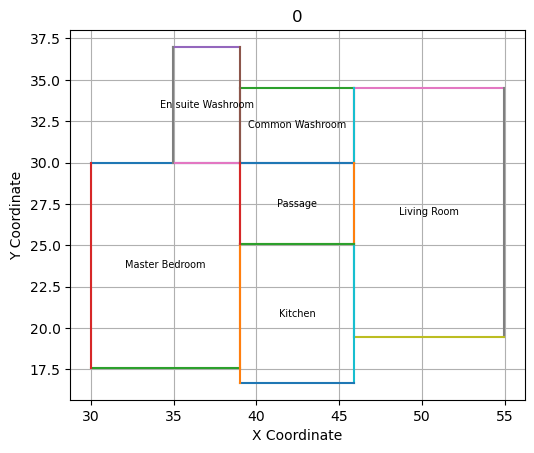

Direction: West
Coords: [[45.9, 19.47], [45.9, 34.52]]
Opposite direction: East
oppo coords : [[45.9, 19.47], [45.9, 34.52]]
New top left: [45.9, 26.47]


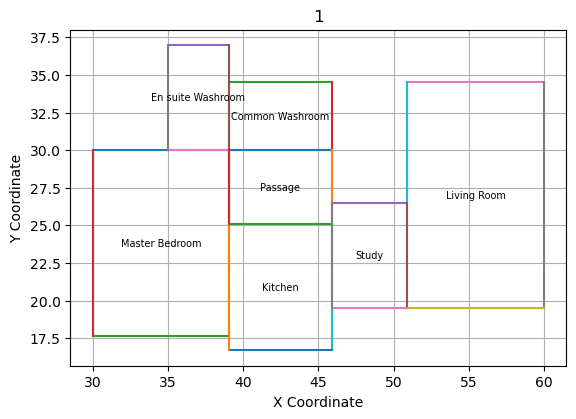

partial_overlaps {}
{('Common Washroom', 'Living Room'): {'Unshifted Room': 'Common Washroom', 'Shifted': {'Living Room': {'Direction': 'East', 'Length': '5.0 units'}}}}


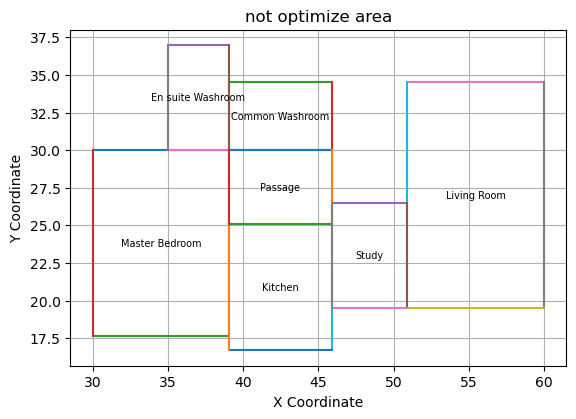

In [17]:


# Example usage, ensure the room details and adjustment_info are set correctly.


def main():
    global rooms, metadata
    rooms = {
'Master Bedroom': [[[30, 30], [39.04, 30]],
  [[39.04, 30], [39.04, 17.61]],
  [[39.04, 17.61], [30, 17.61]],
  [[30, 17.61], [30, 30]]],
 'En suite Washroom': [[[34.97, 36.99], [39.26, 36.99]],
  [[39.26, 36.99], [39.26, 30.0]],
  [[39.26, 30.0], [34.97, 30.0]],
  [[34.97, 30.0], [34.97, 36.99]]],
 'Kitchen': [[[39.04, 25.07], [45.9, 25.07]],
  [[45.9, 25.07], [45.9, 16.68]],
  [[45.9, 16.68], [39.04, 16.68]],
  [[39.04, 16.68], [39.04, 25.07]]],
 'Common Washroom': [[[39.26, 34.52], [45.9, 34.52]],
  [[45.9, 34.52], [45.9, 30.0]],
  [[45.9, 30.0], [39.26, 30.0]],
  [[39.26, 30.0], [39.26, 34.52]]],
 'Living Room': [[[45.9, 34.52], [54.98, 34.52]],
  [[54.98, 34.52], [54.98, 19.47]],
  [[54.98, 19.47], [45.9, 19.47]],
  [[45.9, 19.47], [45.9, 34.52]]],
 'Passage': [[[39.04, 30], [45.9, 30]],
  [[45.9, 30], [45.9, 25.07]],
  [[45.9, 25.07], [39.04, 25.07]],
  [[39.04, 25.07], [39.04, 30]]]
    }



    rooms = replace_near_values(rooms, threshold=0.3)
    rooms1=copy.deepcopy(rooms)
    plot_floor_plan(rooms, title='0')
    new_room_name = "Study"
    length =5
    width = 7
    existing_room = "Living Room"
    direction = "Left"
    metadata = make_roomdata(rooms)

    updated_room_data = add_new_room(rooms, new_room_name, length, width, existing_room, direction, metadata)
    updated_room_data = replace_near_values(updated_room_data, threshold=0.3)
    plot_floor_plan(updated_room_data, title='1')
    metadata=make_roomdata(updated_room_data)
    partial_overlaps = find_and_calculate_overlaps(updated_room_data)
    print('partial_overlaps',partial_overlaps)

    if partial_overlaps:
        final_rooms = solving_overlap_problem(partial_overlaps, updated_room_data, rooms1, new_room_name)
        plot_floor_plan(final_rooms, title='22')
        metadata = make_roomdata(final_rooms)

        gap_results = find_all_gaps(final_rooms)
        print('gap_results',gap_results)
        update_instructions = create_update_dicts(gap_results, new_room_name=new_room_name, metadata=metadata)
        apply_updates(update_instructions, metadata)

    else:
        
        broken_connections, broken_rooms = compare_floor_plans(rooms1, updated_room_data,new_room_name)

        # Remove duplicate connections
        final_broken_info = remove_duplicate_connections(broken_connections)
        # Remove pairs that broke due to the placement of the Study room
        final_broken_info = filter_broken_connections_due_to_new_room(final_broken_info, new_room_name, updated_room_data)
        shift_analysis_dict = make_shift_analysis_dict(final_broken_info.keys(), updated_room_data, rooms1)
        metadata = make_roomdata(updated_room_data)
        print(shift_analysis_dict)
        stichFloorplan(shift_analysis_dict, metadata, overlap=False)
        Final_updated_rooms = {room: [data['coordinates'] for wall_id, data in walls.items()] for room, walls in metadata.items()}
        plot_floor_plan(Final_updated_rooms, title='not optimize area')
        if partial_overlaps:
            final_rooms = solving_overlap_problem(partial_overlaps, Final_updated_rooms, rooms1, new_room_name)
            plot_floor_plan(final_rooms, title='88')
            print(final_rooms)

if __name__ == "__main__":
    main()
